In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = ''

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'features_clin' : ['CAP','TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASH = getHash(name,[architecture,props])
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_0_0_e_CAP_TFC_UHD_Dig_str_e_1_0_1_con_data_nor_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_nat_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3778099, 833)
(3778099, 8)
validation
(397815, 833)
(397815, 8)
test
(482242, 833)
(482242, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 833)]             0         


 dense (Dense)               (None, 2048)              1708032   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4496264 (17.15 MB)


Trainable params: 4496264 (17.15 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/38 [..............................] - ETA: 7:14 - loss: 2.4426 - STD: 0.0889 - MAE: 0.2202

 2/38 [>.............................] - ETA: 14s - loss: 2.3110 - STD: 0.0625 - MAE: 0.2201 

 3/38 [=>............................] - ETA: 15s - loss: 2.2346 - STD: 0.0446 - MAE: 0.2196

 4/38 [==>...........................] - ETA: 15s - loss: 2.1920 - STD: 0.0428 - MAE: 0.2189

 5/38 [==>...........................] - ETA: 14s - loss: 2.1716 - STD: 0.0483 - MAE: 0.2180

 6/38 [===>..........................] - ETA: 14s - loss: 2.1622 - STD: 0.0549 - MAE: 0.2172

 7/38 [====>.........................] - ETA: 13s - loss: 2.1557 - STD: 0.0594 - MAE: 0.2167

 8/38 [=====>........................] - ETA: 13s - loss: 2.1484 - STD: 0.0614 - MAE: 0.2164

 9/38 [======>.......................] - ETA: 12s - loss: 2.1405 - STD: 0.0613 - MAE: 0.2163

10/38 [======>.......................] - ETA: 12s - loss: 2.1330 - STD: 0.0596 - MAE: 0.2162

11/38 [=======>......................] - ETA: 11s - loss: 2.1264 - STD: 0.0572 - MAE: 0.2163

12/38 [========>.....................] - ETA: 11s - loss: 2.1210 - STD: 0.0545 - MAE: 0.2164

13/38 [=========>....................] - ETA: 10s - loss: 2.1165 - STD: 0.0519 - MAE: 0.2165

14/38 [==========>...................] - ETA: 10s - loss: 2.1127 - STD: 0.0494 - MAE: 0.2166

15/38 [==========>...................] - ETA: 9s - loss: 2.1094 - STD: 0.0473 - MAE: 0.2167 

16/38 [===========>..................] - ETA: 9s - loss: 2.1066 - STD: 0.0456 - MAE: 0.2168

17/38 [============>.................] - ETA: 9s - loss: 2.1041 - STD: 0.0443 - MAE: 0.2168

18/38 [=============>................] - ETA: 8s - loss: 2.1019 - STD: 0.0433 - MAE: 0.2169

19/38 [==============>...............] - ETA: 8s - loss: 2.0998 - STD: 0.0425 - MAE: 0.2169

20/38 [==============>...............] - ETA: 7s - loss: 2.0977 - STD: 0.0420 - MAE: 0.2169

21/38 [===============>..............] - ETA: 7s - loss: 2.0958 - STD: 0.0416 - MAE: 0.2169

22/38 [================>.............] - ETA: 7s - loss: 2.0940 - STD: 0.0413 - MAE: 0.2169

23/38 [=================>............] - ETA: 6s - loss: 2.0922 - STD: 0.0411 - MAE: 0.2169

24/38 [=================>............] - ETA: 6s - loss: 2.0905 - STD: 0.0409 - MAE: 0.2168

25/38 [==================>...........] - ETA: 5s - loss: 2.0890 - STD: 0.0409 - MAE: 0.2168

26/38 [===================>..........] - ETA: 5s - loss: 2.0877 - STD: 0.0409 - MAE: 0.2168

27/38 [====================>.........] - ETA: 4s - loss: 2.0866 - STD: 0.0408 - MAE: 0.2168

28/38 [=====================>........] - ETA: 4s - loss: 2.0854 - STD: 0.0407 - MAE: 0.2168

29/38 [=====================>........] - ETA: 3s - loss: 2.0845 - STD: 0.0406 - MAE: 0.2167

30/38 [======================>.......] - ETA: 3s - loss: 2.0834 - STD: 0.0405 - MAE: 0.2167

31/38 [=======================>......] - ETA: 3s - loss: 2.0825 - STD: 0.0403 - MAE: 0.2167

32/38 [========================>.....] - ETA: 2s - loss: 2.0816 - STD: 0.0400 - MAE: 0.2167

33/38 [=========================>....] - ETA: 2s - loss: 2.0807 - STD: 0.0398 - MAE: 0.2167

34/38 [=========================>....] - ETA: 1s - loss: 2.0799 - STD: 0.0395 - MAE: 0.2167

35/38 [==========================>...] - ETA: 1s - loss: 2.0791 - STD: 0.0392 - MAE: 0.2167

36/38 [===========================>..] - ETA: 0s - loss: 2.0783 - STD: 0.0389 - MAE: 0.2167

37/38 [============================>.] - ETA: 0s - loss: 2.0776 - STD: 0.0387 - MAE: 0.2168

38/38 [==============================] - ETA: 0s - loss: 2.0771 - STD: 0.0385 - MAE: 0.2168

38/38 [==============================] - 40s 768ms/step - loss: 2.0771 - STD: 0.0385 - MAE: 0.2168 - val_loss: 2.0535 - val_STD: 0.0309 - val_MAE: 0.2169


Epoch 2/10000


 1/38 [..............................] - ETA: 29s - loss: 2.0520 - STD: 0.0309 - MAE: 0.2168

 2/38 [>.............................] - ETA: 23s - loss: 2.0524 - STD: 0.0311 - MAE: 0.2168

 3/38 [=>............................] - ETA: 18s - loss: 2.0522 - STD: 0.0312 - MAE: 0.2168

 4/38 [==>...........................] - ETA: 18s - loss: 2.0525 - STD: 0.0313 - MAE: 0.2168

 5/38 [==>...........................] - ETA: 16s - loss: 2.0523 - STD: 0.0313 - MAE: 0.2168

 6/38 [===>..........................] - ETA: 16s - loss: 2.0520 - STD: 0.0313 - MAE: 0.2168

 7/38 [====>.........................] - ETA: 15s - loss: 2.0519 - STD: 0.0312 - MAE: 0.2168

 8/38 [=====>........................] - ETA: 14s - loss: 2.0518 - STD: 0.0312 - MAE: 0.2168

 9/38 [======>.......................] - ETA: 14s - loss: 2.0517 - STD: 0.0312 - MAE: 0.2168

10/38 [======>.......................] - ETA: 13s - loss: 2.0516 - STD: 0.0312 - MAE: 0.2168

11/38 [=======>......................] - ETA: 12s - loss: 2.0516 - STD: 0.0313 - MAE: 0.2168

12/38 [========>.....................] - ETA: 12s - loss: 2.0515 - STD: 0.0314 - MAE: 0.2168

13/38 [=========>....................] - ETA: 11s - loss: 2.0514 - STD: 0.0316 - MAE: 0.2167

14/38 [==========>...................] - ETA: 10s - loss: 2.0513 - STD: 0.0317 - MAE: 0.2167

15/38 [==========>...................] - ETA: 10s - loss: 2.0513 - STD: 0.0318 - MAE: 0.2167

16/38 [===========>..................] - ETA: 9s - loss: 2.0512 - STD: 0.0319 - MAE: 0.2167 

17/38 [============>.................] - ETA: 9s - loss: 2.0510 - STD: 0.0320 - MAE: 0.2167

18/38 [=============>................] - ETA: 8s - loss: 2.0508 - STD: 0.0320 - MAE: 0.2167

19/38 [==============>...............] - ETA: 8s - loss: 2.0507 - STD: 0.0320 - MAE: 0.2167

20/38 [==============>...............] - ETA: 7s - loss: 2.0505 - STD: 0.0320 - MAE: 0.2167

21/38 [===============>..............] - ETA: 7s - loss: 2.0503 - STD: 0.0319 - MAE: 0.2167

22/38 [================>.............] - ETA: 6s - loss: 2.0500 - STD: 0.0319 - MAE: 0.2167

23/38 [=================>............] - ETA: 6s - loss: 2.0498 - STD: 0.0318 - MAE: 0.2167

24/38 [=================>............] - ETA: 5s - loss: 2.0495 - STD: 0.0318 - MAE: 0.2167

25/38 [==================>...........] - ETA: 5s - loss: 2.0491 - STD: 0.0317 - MAE: 0.2167

26/38 [===================>..........] - ETA: 5s - loss: 2.0486 - STD: 0.0317 - MAE: 0.2166

27/38 [====================>.........] - ETA: 4s - loss: 2.0481 - STD: 0.0317 - MAE: 0.2166

28/38 [=====================>........] - ETA: 4s - loss: 2.0475 - STD: 0.0317 - MAE: 0.2166

29/38 [=====================>........] - ETA: 3s - loss: 2.0469 - STD: 0.0317 - MAE: 0.2166

30/38 [======================>.......] - ETA: 3s - loss: 2.0462 - STD: 0.0317 - MAE: 0.2166

31/38 [=======================>......] - ETA: 2s - loss: 2.0452 - STD: 0.0318 - MAE: 0.2165

32/38 [========================>.....] - ETA: 2s - loss: 2.0442 - STD: 0.0319 - MAE: 0.2165

33/38 [=========================>....] - ETA: 2s - loss: 2.0430 - STD: 0.0319 - MAE: 0.2164

34/38 [=========================>....] - ETA: 1s - loss: 2.0416 - STD: 0.0320 - MAE: 0.2164

35/38 [==========================>...] - ETA: 1s - loss: 2.0401 - STD: 0.0321 - MAE: 0.2163

36/38 [===========================>..] - ETA: 0s - loss: 2.0384 - STD: 0.0323 - MAE: 0.2163

37/38 [============================>.] - ETA: 0s - loss: 2.0364 - STD: 0.0325 - MAE: 0.2162

38/38 [==============================] - ETA: 0s - loss: 2.0343 - STD: 0.0327 - MAE: 0.2161

38/38 [==============================] - 18s 454ms/step - loss: 2.0343 - STD: 0.0327 - MAE: 0.2161 - val_loss: 1.9336 - val_STD: 0.0441 - val_MAE: 0.2120


Epoch 3/10000


 1/38 [..............................] - ETA: 26s - loss: 1.9401 - STD: 0.0428 - MAE: 0.2124

 2/38 [>.............................] - ETA: 14s - loss: 1.9336 - STD: 0.0442 - MAE: 0.2121

 3/38 [=>............................] - ETA: 13s - loss: 1.9268 - STD: 0.0460 - MAE: 0.2117

 4/38 [==>...........................] - ETA: 13s - loss: 1.9196 - STD: 0.0480 - MAE: 0.2113

 5/38 [==>...........................] - ETA: 12s - loss: 1.9130 - STD: 0.0499 - MAE: 0.2109

 6/38 [===>..........................] - ETA: 12s - loss: 1.9071 - STD: 0.0522 - MAE: 0.2105

 7/38 [====>.........................] - ETA: 12s - loss: 1.9018 - STD: 0.0542 - MAE: 0.2101

 8/38 [=====>........................] - ETA: 12s - loss: 1.8957 - STD: 0.0563 - MAE: 0.2097

 9/38 [======>.......................] - ETA: 11s - loss: 1.8909 - STD: 0.0584 - MAE: 0.2093

10/38 [======>.......................] - ETA: 11s - loss: 1.8857 - STD: 0.0602 - MAE: 0.2089

11/38 [=======>......................] - ETA: 10s - loss: 1.8805 - STD: 0.0618 - MAE: 0.2086

12/38 [========>.....................] - ETA: 10s - loss: 1.8759 - STD: 0.0632 - MAE: 0.2083

13/38 [=========>....................] - ETA: 10s - loss: 1.8709 - STD: 0.0644 - MAE: 0.2080

14/38 [==========>...................] - ETA: 9s - loss: 1.8662 - STD: 0.0654 - MAE: 0.2077 

15/38 [==========>...................] - ETA: 9s - loss: 1.8623 - STD: 0.0663 - MAE: 0.2075

16/38 [===========>..................] - ETA: 8s - loss: 1.8580 - STD: 0.0671 - MAE: 0.2073

17/38 [============>.................] - ETA: 8s - loss: 1.8534 - STD: 0.0680 - MAE: 0.2070

18/38 [=============>................] - ETA: 8s - loss: 1.8493 - STD: 0.0691 - MAE: 0.2067

19/38 [==============>...............] - ETA: 7s - loss: 1.8452 - STD: 0.0701 - MAE: 0.2065

20/38 [==============>...............] - ETA: 7s - loss: 1.8409 - STD: 0.0710 - MAE: 0.2062

21/38 [===============>..............] - ETA: 6s - loss: 1.8369 - STD: 0.0719 - MAE: 0.2060

22/38 [================>.............] - ETA: 6s - loss: 1.8332 - STD: 0.0726 - MAE: 0.2058

23/38 [=================>............] - ETA: 6s - loss: 1.8293 - STD: 0.0733 - MAE: 0.2056

24/38 [=================>............] - ETA: 5s - loss: 1.8254 - STD: 0.0739 - MAE: 0.2054

25/38 [==================>...........] - ETA: 5s - loss: 1.8219 - STD: 0.0745 - MAE: 0.2052

26/38 [===================>..........] - ETA: 4s - loss: 1.8187 - STD: 0.0751 - MAE: 0.2050

27/38 [====================>.........] - ETA: 4s - loss: 1.8152 - STD: 0.0757 - MAE: 0.2048

28/38 [=====================>........] - ETA: 4s - loss: 1.8119 - STD: 0.0764 - MAE: 0.2046

29/38 [=====================>........] - ETA: 3s - loss: 1.8088 - STD: 0.0770 - MAE: 0.2045

30/38 [======================>.......] - ETA: 3s - loss: 1.8059 - STD: 0.0775 - MAE: 0.2043

31/38 [=======================>......] - ETA: 2s - loss: 1.8029 - STD: 0.0781 - MAE: 0.2041

32/38 [========================>.....] - ETA: 2s - loss: 1.7999 - STD: 0.0786 - MAE: 0.2040

33/38 [=========================>....] - ETA: 2s - loss: 1.7972 - STD: 0.0790 - MAE: 0.2038

34/38 [=========================>....] - ETA: 1s - loss: 1.7945 - STD: 0.0795 - MAE: 0.2037

35/38 [==========================>...] - ETA: 1s - loss: 1.7924 - STD: 0.0800 - MAE: 0.2035

36/38 [===========================>..] - ETA: 0s - loss: 1.7896 - STD: 0.0805 - MAE: 0.2034

37/38 [============================>.] - ETA: 0s - loss: 1.7872 - STD: 0.0810 - MAE: 0.2032

38/38 [==============================] - ETA: 0s - loss: 1.7847 - STD: 0.0814 - MAE: 0.2031

38/38 [==============================] - 17s 446ms/step - loss: 1.7847 - STD: 0.0814 - MAE: 0.2031 - val_loss: 1.7017 - val_STD: 0.0965 - val_MAE: 0.1981


Epoch 4/10000


 1/38 [..............................] - ETA: 28s - loss: 1.6879 - STD: 0.0977 - MAE: 0.1977

 2/38 [>.............................] - ETA: 13s - loss: 1.6879 - STD: 0.0988 - MAE: 0.1975

 3/38 [=>............................] - ETA: 14s - loss: 1.6869 - STD: 0.0985 - MAE: 0.1975

 4/38 [==>...........................] - ETA: 13s - loss: 1.6852 - STD: 0.0995 - MAE: 0.1973

 5/38 [==>...........................] - ETA: 13s - loss: 1.6832 - STD: 0.1000 - MAE: 0.1971

 6/38 [===>..........................] - ETA: 12s - loss: 1.6812 - STD: 0.1001 - MAE: 0.1970

 7/38 [====>.........................] - ETA: 12s - loss: 1.6800 - STD: 0.1006 - MAE: 0.1969

 8/38 [=====>........................] - ETA: 11s - loss: 1.6792 - STD: 0.1006 - MAE: 0.1969

 9/38 [======>.......................] - ETA: 11s - loss: 1.6781 - STD: 0.1008 - MAE: 0.1968

10/38 [======>.......................] - ETA: 11s - loss: 1.6770 - STD: 0.1011 - MAE: 0.1967

11/38 [=======>......................] - ETA: 10s - loss: 1.6764 - STD: 0.1012 - MAE: 0.1967

12/38 [========>.....................] - ETA: 10s - loss: 1.6760 - STD: 0.1016 - MAE: 0.1966

13/38 [=========>....................] - ETA: 10s - loss: 1.6755 - STD: 0.1016 - MAE: 0.1966

14/38 [==========>...................] - ETA: 9s - loss: 1.6744 - STD: 0.1019 - MAE: 0.1965 

15/38 [==========>...................] - ETA: 9s - loss: 1.6730 - STD: 0.1021 - MAE: 0.1964

16/38 [===========>..................] - ETA: 8s - loss: 1.6715 - STD: 0.1023 - MAE: 0.1963

17/38 [============>.................] - ETA: 8s - loss: 1.6705 - STD: 0.1027 - MAE: 0.1962

18/38 [=============>................] - ETA: 8s - loss: 1.6695 - STD: 0.1028 - MAE: 0.1961

19/38 [==============>...............] - ETA: 7s - loss: 1.6686 - STD: 0.1031 - MAE: 0.1960

20/38 [==============>...............] - ETA: 7s - loss: 1.6675 - STD: 0.1033 - MAE: 0.1960

21/38 [===============>..............] - ETA: 6s - loss: 1.6663 - STD: 0.1035 - MAE: 0.1959

22/38 [================>.............] - ETA: 6s - loss: 1.6653 - STD: 0.1037 - MAE: 0.1958

23/38 [=================>............] - ETA: 6s - loss: 1.6643 - STD: 0.1039 - MAE: 0.1957

24/38 [=================>............] - ETA: 5s - loss: 1.6634 - STD: 0.1042 - MAE: 0.1956

25/38 [==================>...........] - ETA: 5s - loss: 1.6624 - STD: 0.1043 - MAE: 0.1956

26/38 [===================>..........] - ETA: 4s - loss: 1.6615 - STD: 0.1045 - MAE: 0.1955

27/38 [====================>.........] - ETA: 4s - loss: 1.6605 - STD: 0.1047 - MAE: 0.1954

28/38 [=====================>........] - ETA: 4s - loss: 1.6596 - STD: 0.1049 - MAE: 0.1954

29/38 [=====================>........] - ETA: 3s - loss: 1.6586 - STD: 0.1051 - MAE: 0.1953

30/38 [======================>.......] - ETA: 3s - loss: 1.6577 - STD: 0.1053 - MAE: 0.1952

31/38 [=======================>......] - ETA: 2s - loss: 1.6568 - STD: 0.1054 - MAE: 0.1952

32/38 [========================>.....] - ETA: 2s - loss: 1.6559 - STD: 0.1057 - MAE: 0.1951

33/38 [=========================>....] - ETA: 2s - loss: 1.6550 - STD: 0.1058 - MAE: 0.1950

34/38 [=========================>....] - ETA: 1s - loss: 1.6544 - STD: 0.1060 - MAE: 0.1950

35/38 [==========================>...] - ETA: 1s - loss: 1.6537 - STD: 0.1061 - MAE: 0.1949

36/38 [===========================>..] - ETA: 0s - loss: 1.6534 - STD: 0.1064 - MAE: 0.1949

37/38 [============================>.] - ETA: 0s - loss: 1.6536 - STD: 0.1065 - MAE: 0.1948

38/38 [==============================] - ETA: 0s - loss: 1.6531 - STD: 0.1067 - MAE: 0.1948

38/38 [==============================] - 17s 442ms/step - loss: 1.6531 - STD: 0.1067 - MAE: 0.1948 - val_loss: 1.6458 - val_STD: 0.1095 - val_MAE: 0.1937


Epoch 5/10000


 1/38 [..............................] - ETA: 25s - loss: 1.6166 - STD: 0.1121 - MAE: 0.1924

 2/38 [>.............................] - ETA: 14s - loss: 1.6261 - STD: 0.1123 - MAE: 0.1927

 3/38 [=>............................] - ETA: 14s - loss: 1.6283 - STD: 0.1143 - MAE: 0.1923

 4/38 [==>...........................] - ETA: 13s - loss: 1.6233 - STD: 0.1139 - MAE: 0.1922

 5/38 [==>...........................] - ETA: 13s - loss: 1.6240 - STD: 0.1131 - MAE: 0.1924

 6/38 [===>..........................] - ETA: 12s - loss: 1.6226 - STD: 0.1134 - MAE: 0.1923

 7/38 [====>.........................] - ETA: 12s - loss: 1.6202 - STD: 0.1136 - MAE: 0.1922

 8/38 [=====>........................] - ETA: 12s - loss: 1.6203 - STD: 0.1136 - MAE: 0.1922

 9/38 [======>.......................] - ETA: 11s - loss: 1.6186 - STD: 0.1139 - MAE: 0.1920

10/38 [======>.......................] - ETA: 11s - loss: 1.6172 - STD: 0.1139 - MAE: 0.1920

11/38 [=======>......................] - ETA: 10s - loss: 1.6164 - STD: 0.1137 - MAE: 0.1920

12/38 [========>.....................] - ETA: 10s - loss: 1.6147 - STD: 0.1138 - MAE: 0.1919

13/38 [=========>....................] - ETA: 10s - loss: 1.6136 - STD: 0.1141 - MAE: 0.1918

14/38 [==========>...................] - ETA: 9s - loss: 1.6124 - STD: 0.1142 - MAE: 0.1918 

15/38 [==========>...................] - ETA: 9s - loss: 1.6112 - STD: 0.1142 - MAE: 0.1917

16/38 [===========>..................] - ETA: 8s - loss: 1.6100 - STD: 0.1143 - MAE: 0.1916

17/38 [============>.................] - ETA: 8s - loss: 1.6087 - STD: 0.1144 - MAE: 0.1916

18/38 [=============>................] - ETA: 8s - loss: 1.6073 - STD: 0.1145 - MAE: 0.1915

19/38 [==============>...............] - ETA: 7s - loss: 1.6063 - STD: 0.1147 - MAE: 0.1914

20/38 [==============>...............] - ETA: 7s - loss: 1.6049 - STD: 0.1147 - MAE: 0.1914

21/38 [===============>..............] - ETA: 6s - loss: 1.6035 - STD: 0.1147 - MAE: 0.1913

22/38 [================>.............] - ETA: 6s - loss: 1.6023 - STD: 0.1148 - MAE: 0.1912

23/38 [=================>............] - ETA: 6s - loss: 1.6009 - STD: 0.1149 - MAE: 0.1912

24/38 [=================>............] - ETA: 5s - loss: 1.5993 - STD: 0.1150 - MAE: 0.1911

25/38 [==================>...........] - ETA: 5s - loss: 1.5978 - STD: 0.1151 - MAE: 0.1910

26/38 [===================>..........] - ETA: 4s - loss: 1.5961 - STD: 0.1152 - MAE: 0.1909

27/38 [====================>.........] - ETA: 4s - loss: 1.5944 - STD: 0.1153 - MAE: 0.1908

28/38 [=====================>........] - ETA: 4s - loss: 1.5926 - STD: 0.1154 - MAE: 0.1907

29/38 [=====================>........] - ETA: 3s - loss: 1.5905 - STD: 0.1155 - MAE: 0.1906

30/38 [======================>.......] - ETA: 3s - loss: 1.5883 - STD: 0.1156 - MAE: 0.1905

31/38 [=======================>......] - ETA: 2s - loss: 1.5861 - STD: 0.1157 - MAE: 0.1904

32/38 [========================>.....] - ETA: 2s - loss: 1.5835 - STD: 0.1158 - MAE: 0.1902

33/38 [=========================>....] - ETA: 2s - loss: 1.5808 - STD: 0.1160 - MAE: 0.1901

34/38 [=========================>....] - ETA: 1s - loss: 1.5781 - STD: 0.1162 - MAE: 0.1899

35/38 [==========================>...] - ETA: 1s - loss: 1.5759 - STD: 0.1164 - MAE: 0.1898

36/38 [===========================>..] - ETA: 0s - loss: 1.5729 - STD: 0.1166 - MAE: 0.1896

37/38 [============================>.] - ETA: 0s - loss: 1.5699 - STD: 0.1169 - MAE: 0.1894

38/38 [==============================] - ETA: 0s - loss: 1.5669 - STD: 0.1172 - MAE: 0.1892

38/38 [==============================] - 17s 453ms/step - loss: 1.5669 - STD: 0.1172 - MAE: 0.1892 - val_loss: 1.5184 - val_STD: 0.1310 - val_MAE: 0.1833


Epoch 6/10000


 1/38 [..............................] - ETA: 38s - loss: 1.4533 - STD: 0.1312 - MAE: 0.1808

 2/38 [>.............................] - ETA: 16s - loss: 1.4396 - STD: 0.1317 - MAE: 0.1803

 3/38 [=>............................] - ETA: 15s - loss: 1.4278 - STD: 0.1326 - MAE: 0.1796

 4/38 [==>...........................] - ETA: 16s - loss: 1.4225 - STD: 0.1336 - MAE: 0.1791

 5/38 [==>...........................] - ETA: 16s - loss: 1.4199 - STD: 0.1341 - MAE: 0.1789

 6/38 [===>..........................] - ETA: 15s - loss: 1.4168 - STD: 0.1351 - MAE: 0.1785

 7/38 [====>.........................] - ETA: 14s - loss: 1.4126 - STD: 0.1357 - MAE: 0.1781

 8/38 [=====>........................] - ETA: 14s - loss: 1.4079 - STD: 0.1364 - MAE: 0.1778

 9/38 [======>.......................] - ETA: 14s - loss: 1.4050 - STD: 0.1373 - MAE: 0.1774

10/38 [======>.......................] - ETA: 13s - loss: 1.4025 - STD: 0.1379 - MAE: 0.1771

11/38 [=======>......................] - ETA: 12s - loss: 1.4001 - STD: 0.1387 - MAE: 0.1768

12/38 [========>.....................] - ETA: 12s - loss: 1.3966 - STD: 0.1393 - MAE: 0.1765

13/38 [=========>....................] - ETA: 11s - loss: 1.3932 - STD: 0.1399 - MAE: 0.1762

14/38 [==========>...................] - ETA: 11s - loss: 1.3910 - STD: 0.1405 - MAE: 0.1759

15/38 [==========>...................] - ETA: 10s - loss: 1.3890 - STD: 0.1409 - MAE: 0.1757

16/38 [===========>..................] - ETA: 10s - loss: 1.3861 - STD: 0.1415 - MAE: 0.1754

17/38 [============>.................] - ETA: 9s - loss: 1.3833 - STD: 0.1419 - MAE: 0.1752 

18/38 [=============>................] - ETA: 9s - loss: 1.3815 - STD: 0.1423 - MAE: 0.1750

19/38 [==============>...............] - ETA: 8s - loss: 1.3800 - STD: 0.1428 - MAE: 0.1747

20/38 [==============>...............] - ETA: 8s - loss: 1.3778 - STD: 0.1432 - MAE: 0.1745

21/38 [===============>..............] - ETA: 7s - loss: 1.3760 - STD: 0.1436 - MAE: 0.1743

22/38 [================>.............] - ETA: 7s - loss: 1.3739 - STD: 0.1441 - MAE: 0.1741

23/38 [=================>............] - ETA: 6s - loss: 1.3721 - STD: 0.1444 - MAE: 0.1739

24/38 [=================>............] - ETA: 6s - loss: 1.3701 - STD: 0.1448 - MAE: 0.1737

25/38 [==================>...........] - ETA: 5s - loss: 1.3679 - STD: 0.1451 - MAE: 0.1735

26/38 [===================>..........] - ETA: 5s - loss: 1.3659 - STD: 0.1454 - MAE: 0.1734

27/38 [====================>.........] - ETA: 4s - loss: 1.3641 - STD: 0.1457 - MAE: 0.1732

28/38 [=====================>........] - ETA: 4s - loss: 1.3622 - STD: 0.1460 - MAE: 0.1730

29/38 [=====================>........] - ETA: 4s - loss: 1.3603 - STD: 0.1463 - MAE: 0.1728

30/38 [======================>.......] - ETA: 3s - loss: 1.3587 - STD: 0.1466 - MAE: 0.1726

31/38 [=======================>......] - ETA: 3s - loss: 1.3572 - STD: 0.1469 - MAE: 0.1725

32/38 [========================>.....] - ETA: 2s - loss: 1.3556 - STD: 0.1472 - MAE: 0.1723

33/38 [=========================>....] - ETA: 2s - loss: 1.3541 - STD: 0.1474 - MAE: 0.1722

34/38 [=========================>....] - ETA: 1s - loss: 1.3527 - STD: 0.1477 - MAE: 0.1720

35/38 [==========================>...] - ETA: 1s - loss: 1.3510 - STD: 0.1480 - MAE: 0.1719

36/38 [===========================>..] - ETA: 0s - loss: 1.3496 - STD: 0.1482 - MAE: 0.1717

37/38 [============================>.] - ETA: 0s - loss: 1.3481 - STD: 0.1484 - MAE: 0.1716

38/38 [==============================] - ETA: 0s - loss: 1.3467 - STD: 0.1487 - MAE: 0.1714

38/38 [==============================] - 19s 486ms/step - loss: 1.3467 - STD: 0.1487 - MAE: 0.1714 - val_loss: 1.3678 - val_STD: 0.1570 - val_MAE: 0.1686


Epoch 7/10000


 1/38 [..............................] - ETA: 30s - loss: 1.2956 - STD: 0.1575 - MAE: 0.1660

 2/38 [>.............................] - ETA: 16s - loss: 1.2999 - STD: 0.1584 - MAE: 0.1658

 3/38 [=>............................] - ETA: 15s - loss: 1.3057 - STD: 0.1584 - MAE: 0.1661

 4/38 [==>...........................] - ETA: 14s - loss: 1.3099 - STD: 0.1589 - MAE: 0.1661

 5/38 [==>...........................] - ETA: 13s - loss: 1.3084 - STD: 0.1590 - MAE: 0.1660

 6/38 [===>..........................] - ETA: 13s - loss: 1.3056 - STD: 0.1592 - MAE: 0.1658

 7/38 [====>.........................] - ETA: 13s - loss: 1.3025 - STD: 0.1592 - MAE: 0.1656

 8/38 [=====>........................] - ETA: 12s - loss: 1.3007 - STD: 0.1592 - MAE: 0.1655

 9/38 [======>.......................] - ETA: 12s - loss: 1.2998 - STD: 0.1594 - MAE: 0.1654

10/38 [======>.......................] - ETA: 11s - loss: 1.2983 - STD: 0.1594 - MAE: 0.1653

11/38 [=======>......................] - ETA: 11s - loss: 1.2964 - STD: 0.1595 - MAE: 0.1652

12/38 [========>.....................] - ETA: 11s - loss: 1.2944 - STD: 0.1597 - MAE: 0.1650

13/38 [=========>....................] - ETA: 10s - loss: 1.2929 - STD: 0.1598 - MAE: 0.1649

14/38 [==========>...................] - ETA: 10s - loss: 1.2918 - STD: 0.1599 - MAE: 0.1648

15/38 [==========>...................] - ETA: 9s - loss: 1.2905 - STD: 0.1601 - MAE: 0.1647 

16/38 [===========>..................] - ETA: 9s - loss: 1.2892 - STD: 0.1602 - MAE: 0.1645

17/38 [============>.................] - ETA: 9s - loss: 1.2875 - STD: 0.1604 - MAE: 0.1644

18/38 [=============>................] - ETA: 8s - loss: 1.2861 - STD: 0.1606 - MAE: 0.1642

19/38 [==============>...............] - ETA: 8s - loss: 1.2849 - STD: 0.1607 - MAE: 0.1641

20/38 [==============>...............] - ETA: 7s - loss: 1.2834 - STD: 0.1608 - MAE: 0.1640

21/38 [===============>..............] - ETA: 7s - loss: 1.2822 - STD: 0.1610 - MAE: 0.1639

22/38 [================>.............] - ETA: 6s - loss: 1.2809 - STD: 0.1612 - MAE: 0.1638

23/38 [=================>............] - ETA: 6s - loss: 1.2795 - STD: 0.1614 - MAE: 0.1636

24/38 [=================>............] - ETA: 5s - loss: 1.2784 - STD: 0.1615 - MAE: 0.1635

25/38 [==================>...........] - ETA: 5s - loss: 1.2775 - STD: 0.1617 - MAE: 0.1634

26/38 [===================>..........] - ETA: 5s - loss: 1.2763 - STD: 0.1619 - MAE: 0.1633

27/38 [====================>.........] - ETA: 4s - loss: 1.2754 - STD: 0.1620 - MAE: 0.1632

28/38 [=====================>........] - ETA: 4s - loss: 1.2744 - STD: 0.1622 - MAE: 0.1631

29/38 [=====================>........] - ETA: 3s - loss: 1.2736 - STD: 0.1623 - MAE: 0.1629

30/38 [======================>.......] - ETA: 3s - loss: 1.2735 - STD: 0.1625 - MAE: 0.1629

31/38 [=======================>......] - ETA: 2s - loss: 1.2741 - STD: 0.1627 - MAE: 0.1628

32/38 [========================>.....] - ETA: 2s - loss: 1.2748 - STD: 0.1629 - MAE: 0.1628

33/38 [=========================>....] - ETA: 2s - loss: 1.2748 - STD: 0.1631 - MAE: 0.1627

34/38 [=========================>....] - ETA: 1s - loss: 1.2736 - STD: 0.1633 - MAE: 0.1626

35/38 [==========================>...] - ETA: 1s - loss: 1.2730 - STD: 0.1634 - MAE: 0.1625

36/38 [===========================>..] - ETA: 0s - loss: 1.2726 - STD: 0.1636 - MAE: 0.1624

37/38 [============================>.] - ETA: 0s - loss: 1.2719 - STD: 0.1638 - MAE: 0.1623

38/38 [==============================] - ETA: 0s - loss: 1.2710 - STD: 0.1640 - MAE: 0.1622

38/38 [==============================] - 18s 461ms/step - loss: 1.2710 - STD: 0.1640 - MAE: 0.1622 - val_loss: 1.2991 - val_STD: 0.1716 - val_MAE: 0.1594


Epoch 8/10000


 1/38 [..............................] - ETA: 31s - loss: 1.2460 - STD: 0.1693 - MAE: 0.1588

 2/38 [>.............................] - ETA: 13s - loss: 1.2402 - STD: 0.1686 - MAE: 0.1588

 3/38 [=>............................] - ETA: 14s - loss: 1.2392 - STD: 0.1689 - MAE: 0.1587

 4/38 [==>...........................] - ETA: 13s - loss: 1.2386 - STD: 0.1693 - MAE: 0.1585

 5/38 [==>...........................] - ETA: 13s - loss: 1.2376 - STD: 0.1695 - MAE: 0.1584

 6/38 [===>..........................] - ETA: 13s - loss: 1.2361 - STD: 0.1699 - MAE: 0.1582

 7/38 [====>.........................] - ETA: 12s - loss: 1.2352 - STD: 0.1701 - MAE: 0.1581

 8/38 [=====>........................] - ETA: 12s - loss: 1.2344 - STD: 0.1703 - MAE: 0.1580

 9/38 [======>.......................] - ETA: 12s - loss: 1.2335 - STD: 0.1706 - MAE: 0.1578

10/38 [======>.......................] - ETA: 11s - loss: 1.2328 - STD: 0.1707 - MAE: 0.1577

11/38 [=======>......................] - ETA: 11s - loss: 1.2313 - STD: 0.1710 - MAE: 0.1576

12/38 [========>.....................] - ETA: 10s - loss: 1.2308 - STD: 0.1712 - MAE: 0.1575

13/38 [=========>....................] - ETA: 10s - loss: 1.2301 - STD: 0.1713 - MAE: 0.1574

14/38 [==========>...................] - ETA: 9s - loss: 1.2291 - STD: 0.1714 - MAE: 0.1573 

15/38 [==========>...................] - ETA: 9s - loss: 1.2280 - STD: 0.1715 - MAE: 0.1572

16/38 [===========>..................] - ETA: 9s - loss: 1.2276 - STD: 0.1716 - MAE: 0.1572

17/38 [============>.................] - ETA: 8s - loss: 1.2266 - STD: 0.1717 - MAE: 0.1571

18/38 [=============>................] - ETA: 8s - loss: 1.2260 - STD: 0.1718 - MAE: 0.1570

19/38 [==============>...............] - ETA: 7s - loss: 1.2253 - STD: 0.1719 - MAE: 0.1569

20/38 [==============>...............] - ETA: 7s - loss: 1.2246 - STD: 0.1721 - MAE: 0.1569

21/38 [===============>..............] - ETA: 7s - loss: 1.2238 - STD: 0.1722 - MAE: 0.1568

22/38 [================>.............] - ETA: 6s - loss: 1.2233 - STD: 0.1723 - MAE: 0.1567

23/38 [=================>............] - ETA: 6s - loss: 1.2228 - STD: 0.1725 - MAE: 0.1566

24/38 [=================>............] - ETA: 5s - loss: 1.2221 - STD: 0.1726 - MAE: 0.1566

25/38 [==================>...........] - ETA: 5s - loss: 1.2214 - STD: 0.1727 - MAE: 0.1565

26/38 [===================>..........] - ETA: 5s - loss: 1.2208 - STD: 0.1727 - MAE: 0.1564

27/38 [====================>.........] - ETA: 4s - loss: 1.2203 - STD: 0.1728 - MAE: 0.1564

28/38 [=====================>........] - ETA: 4s - loss: 1.2197 - STD: 0.1729 - MAE: 0.1563

29/38 [=====================>........] - ETA: 3s - loss: 1.2192 - STD: 0.1731 - MAE: 0.1562

30/38 [======================>.......] - ETA: 3s - loss: 1.2186 - STD: 0.1732 - MAE: 0.1562

31/38 [=======================>......] - ETA: 2s - loss: 1.2183 - STD: 0.1733 - MAE: 0.1561

32/38 [========================>.....] - ETA: 2s - loss: 1.2177 - STD: 0.1734 - MAE: 0.1560

33/38 [=========================>....] - ETA: 2s - loss: 1.2170 - STD: 0.1735 - MAE: 0.1560

34/38 [=========================>....] - ETA: 1s - loss: 1.2164 - STD: 0.1736 - MAE: 0.1559

35/38 [==========================>...] - ETA: 1s - loss: 1.2157 - STD: 0.1737 - MAE: 0.1558

36/38 [===========================>..] - ETA: 0s - loss: 1.2151 - STD: 0.1738 - MAE: 0.1558

37/38 [============================>.] - ETA: 0s - loss: 1.2146 - STD: 0.1739 - MAE: 0.1557

38/38 [==============================] - ETA: 0s - loss: 1.2142 - STD: 0.1740 - MAE: 0.1556

38/38 [==============================] - 18s 469ms/step - loss: 1.2142 - STD: 0.1740 - MAE: 0.1556 - val_loss: 1.2624 - val_STD: 0.1791 - val_MAE: 0.1546


Epoch 9/10000


 1/38 [..............................] - ETA: 36s - loss: 1.2007 - STD: 0.1785 - MAE: 0.1534

 2/38 [>.............................] - ETA: 16s - loss: 1.2015 - STD: 0.1792 - MAE: 0.1532

 3/38 [=>............................] - ETA: 15s - loss: 1.1998 - STD: 0.1788 - MAE: 0.1532

 4/38 [==>...........................] - ETA: 14s - loss: 1.1978 - STD: 0.1790 - MAE: 0.1531

 5/38 [==>...........................] - ETA: 13s - loss: 1.1961 - STD: 0.1788 - MAE: 0.1530

 6/38 [===>..........................] - ETA: 13s - loss: 1.1950 - STD: 0.1789 - MAE: 0.1530

 7/38 [====>.........................] - ETA: 13s - loss: 1.1936 - STD: 0.1788 - MAE: 0.1529

 8/38 [=====>........................] - ETA: 13s - loss: 1.1923 - STD: 0.1787 - MAE: 0.1529

 9/38 [======>.......................] - ETA: 12s - loss: 1.1926 - STD: 0.1788 - MAE: 0.1529

10/38 [======>.......................] - ETA: 12s - loss: 1.1933 - STD: 0.1789 - MAE: 0.1529

11/38 [=======>......................] - ETA: 12s - loss: 1.1947 - STD: 0.1791 - MAE: 0.1528

12/38 [========>.....................] - ETA: 12s - loss: 1.1959 - STD: 0.1791 - MAE: 0.1529

13/38 [=========>....................] - ETA: 11s - loss: 1.1965 - STD: 0.1792 - MAE: 0.1529

14/38 [==========>...................] - ETA: 11s - loss: 1.1964 - STD: 0.1794 - MAE: 0.1528

15/38 [==========>...................] - ETA: 11s - loss: 1.1957 - STD: 0.1795 - MAE: 0.1528

16/38 [===========>..................] - ETA: 10s - loss: 1.1949 - STD: 0.1796 - MAE: 0.1527

17/38 [============>.................] - ETA: 9s - loss: 1.1945 - STD: 0.1796 - MAE: 0.1527 

18/38 [=============>................] - ETA: 9s - loss: 1.1940 - STD: 0.1795 - MAE: 0.1527

19/38 [==============>...............] - ETA: 8s - loss: 1.1933 - STD: 0.1796 - MAE: 0.1526

20/38 [==============>...............] - ETA: 8s - loss: 1.1927 - STD: 0.1797 - MAE: 0.1525

21/38 [===============>..............] - ETA: 8s - loss: 1.1921 - STD: 0.1798 - MAE: 0.1525

22/38 [================>.............] - ETA: 7s - loss: 1.1918 - STD: 0.1798 - MAE: 0.1525

23/38 [=================>............] - ETA: 7s - loss: 1.1912 - STD: 0.1799 - MAE: 0.1524

24/38 [=================>............] - ETA: 6s - loss: 1.1907 - STD: 0.1799 - MAE: 0.1524

25/38 [==================>...........] - ETA: 6s - loss: 1.1901 - STD: 0.1800 - MAE: 0.1523

26/38 [===================>..........] - ETA: 5s - loss: 1.1896 - STD: 0.1801 - MAE: 0.1522

27/38 [====================>.........] - ETA: 5s - loss: 1.1888 - STD: 0.1802 - MAE: 0.1522

28/38 [=====================>........] - ETA: 4s - loss: 1.1881 - STD: 0.1802 - MAE: 0.1521

29/38 [=====================>........] - ETA: 4s - loss: 1.1876 - STD: 0.1802 - MAE: 0.1521

30/38 [======================>.......] - ETA: 3s - loss: 1.1870 - STD: 0.1803 - MAE: 0.1520

31/38 [=======================>......] - ETA: 3s - loss: 1.1866 - STD: 0.1804 - MAE: 0.1520

32/38 [========================>.....] - ETA: 2s - loss: 1.1862 - STD: 0.1805 - MAE: 0.1519

33/38 [=========================>....] - ETA: 2s - loss: 1.1861 - STD: 0.1806 - MAE: 0.1519

34/38 [=========================>....] - ETA: 1s - loss: 1.1864 - STD: 0.1806 - MAE: 0.1519

35/38 [==========================>...] - ETA: 1s - loss: 1.1867 - STD: 0.1807 - MAE: 0.1519

36/38 [===========================>..] - ETA: 0s - loss: 1.1870 - STD: 0.1808 - MAE: 0.1519

37/38 [============================>.] - ETA: 0s - loss: 1.1869 - STD: 0.1808 - MAE: 0.1518

38/38 [==============================] - ETA: 0s - loss: 1.1865 - STD: 0.1809 - MAE: 0.1518

38/38 [==============================] - 20s 519ms/step - loss: 1.1865 - STD: 0.1809 - MAE: 0.1518 - val_loss: 1.2227 - val_STD: 0.1844 - val_MAE: 0.1509


Epoch 10/10000


 1/38 [..............................] - ETA: 30s - loss: 1.1637 - STD: 0.1836 - MAE: 0.1499

 2/38 [>.............................] - ETA: 15s - loss: 1.1688 - STD: 0.1830 - MAE: 0.1503

 3/38 [=>............................] - ETA: 15s - loss: 1.1743 - STD: 0.1832 - MAE: 0.1505

 4/38 [==>...........................] - ETA: 15s - loss: 1.1782 - STD: 0.1829 - MAE: 0.1507

 5/38 [==>...........................] - ETA: 14s - loss: 1.1760 - STD: 0.1832 - MAE: 0.1505

 6/38 [===>..........................] - ETA: 14s - loss: 1.1734 - STD: 0.1833 - MAE: 0.1503

 7/38 [====>.........................] - ETA: 14s - loss: 1.1738 - STD: 0.1832 - MAE: 0.1504

 8/38 [=====>........................] - ETA: 13s - loss: 1.1741 - STD: 0.1834 - MAE: 0.1503

 9/38 [======>.......................] - ETA: 13s - loss: 1.1740 - STD: 0.1834 - MAE: 0.1503

10/38 [======>.......................] - ETA: 13s - loss: 1.1726 - STD: 0.1834 - MAE: 0.1502

11/38 [=======>......................] - ETA: 12s - loss: 1.1724 - STD: 0.1835 - MAE: 0.1502

12/38 [========>.....................] - ETA: 12s - loss: 1.1723 - STD: 0.1836 - MAE: 0.1502

13/38 [=========>....................] - ETA: 11s - loss: 1.1715 - STD: 0.1836 - MAE: 0.1501

14/38 [==========>...................] - ETA: 10s - loss: 1.1706 - STD: 0.1837 - MAE: 0.1500

15/38 [==========>...................] - ETA: 10s - loss: 1.1705 - STD: 0.1837 - MAE: 0.1500

16/38 [===========>..................] - ETA: 9s - loss: 1.1701 - STD: 0.1839 - MAE: 0.1500 

17/38 [============>.................] - ETA: 9s - loss: 1.1696 - STD: 0.1839 - MAE: 0.1499

18/38 [=============>................] - ETA: 8s - loss: 1.1696 - STD: 0.1840 - MAE: 0.1499

19/38 [==============>...............] - ETA: 8s - loss: 1.1705 - STD: 0.1841 - MAE: 0.1499

20/38 [==============>...............] - ETA: 7s - loss: 1.1712 - STD: 0.1841 - MAE: 0.1499

21/38 [===============>..............] - ETA: 7s - loss: 1.1710 - STD: 0.1841 - MAE: 0.1499

22/38 [================>.............] - ETA: 7s - loss: 1.1703 - STD: 0.1842 - MAE: 0.1498

23/38 [=================>............] - ETA: 6s - loss: 1.1699 - STD: 0.1842 - MAE: 0.1498

24/38 [=================>............] - ETA: 6s - loss: 1.1693 - STD: 0.1843 - MAE: 0.1497

25/38 [==================>...........] - ETA: 5s - loss: 1.1688 - STD: 0.1843 - MAE: 0.1497

26/38 [===================>..........] - ETA: 5s - loss: 1.1681 - STD: 0.1843 - MAE: 0.1497

27/38 [====================>.........] - ETA: 4s - loss: 1.1679 - STD: 0.1844 - MAE: 0.1496

28/38 [=====================>........] - ETA: 4s - loss: 1.1675 - STD: 0.1844 - MAE: 0.1496

29/38 [=====================>........] - ETA: 3s - loss: 1.1670 - STD: 0.1845 - MAE: 0.1496

30/38 [======================>.......] - ETA: 3s - loss: 1.1665 - STD: 0.1845 - MAE: 0.1495

31/38 [=======================>......] - ETA: 3s - loss: 1.1661 - STD: 0.1845 - MAE: 0.1495

32/38 [========================>.....] - ETA: 2s - loss: 1.1657 - STD: 0.1846 - MAE: 0.1495

33/38 [=========================>....] - ETA: 2s - loss: 1.1651 - STD: 0.1846 - MAE: 0.1494

34/38 [=========================>....] - ETA: 1s - loss: 1.1646 - STD: 0.1847 - MAE: 0.1494

35/38 [==========================>...] - ETA: 1s - loss: 1.1640 - STD: 0.1847 - MAE: 0.1493

36/38 [===========================>..] - ETA: 0s - loss: 1.1636 - STD: 0.1847 - MAE: 0.1493

37/38 [============================>.] - ETA: 0s - loss: 1.1633 - STD: 0.1848 - MAE: 0.1493

38/38 [==============================] - ETA: 0s - loss: 1.1629 - STD: 0.1848 - MAE: 0.1492

38/38 [==============================] - 18s 466ms/step - loss: 1.1629 - STD: 0.1848 - MAE: 0.1492 - val_loss: 1.2071 - val_STD: 0.1864 - val_MAE: 0.1493


Epoch 11/10000


 1/38 [..............................] - ETA: 24s - loss: 1.1470 - STD: 0.1863 - MAE: 0.1479

 2/38 [>.............................] - ETA: 13s - loss: 1.1471 - STD: 0.1873 - MAE: 0.1476

 3/38 [=>............................] - ETA: 13s - loss: 1.1471 - STD: 0.1869 - MAE: 0.1477

 4/38 [==>...........................] - ETA: 14s - loss: 1.1487 - STD: 0.1872 - MAE: 0.1477

 5/38 [==>...........................] - ETA: 13s - loss: 1.1529 - STD: 0.1868 - MAE: 0.1481

 6/38 [===>..........................] - ETA: 13s - loss: 1.1562 - STD: 0.1873 - MAE: 0.1480

 7/38 [====>.........................] - ETA: 12s - loss: 1.1615 - STD: 0.1871 - MAE: 0.1484

 8/38 [=====>........................] - ETA: 12s - loss: 1.1673 - STD: 0.1873 - MAE: 0.1485

 9/38 [======>.......................] - ETA: 11s - loss: 1.1715 - STD: 0.1874 - MAE: 0.1487

10/38 [======>.......................] - ETA: 11s - loss: 1.1734 - STD: 0.1874 - MAE: 0.1488

11/38 [=======>......................] - ETA: 11s - loss: 1.1716 - STD: 0.1874 - MAE: 0.1487

12/38 [========>.....................] - ETA: 10s - loss: 1.1709 - STD: 0.1873 - MAE: 0.1487

13/38 [=========>....................] - ETA: 10s - loss: 1.1727 - STD: 0.1872 - MAE: 0.1488

14/38 [==========>...................] - ETA: 9s - loss: 1.1718 - STD: 0.1872 - MAE: 0.1488 

15/38 [==========>...................] - ETA: 9s - loss: 1.1702 - STD: 0.1872 - MAE: 0.1487

16/38 [===========>..................] - ETA: 8s - loss: 1.1703 - STD: 0.1872 - MAE: 0.1487

17/38 [============>.................] - ETA: 8s - loss: 1.1695 - STD: 0.1872 - MAE: 0.1487

18/38 [=============>................] - ETA: 8s - loss: 1.1679 - STD: 0.1872 - MAE: 0.1486

19/38 [==============>...............] - ETA: 7s - loss: 1.1675 - STD: 0.1873 - MAE: 0.1486

20/38 [==============>...............] - ETA: 7s - loss: 1.1666 - STD: 0.1872 - MAE: 0.1486

21/38 [===============>..............] - ETA: 6s - loss: 1.1654 - STD: 0.1872 - MAE: 0.1485

22/38 [================>.............] - ETA: 6s - loss: 1.1650 - STD: 0.1871 - MAE: 0.1485

23/38 [=================>............] - ETA: 6s - loss: 1.1642 - STD: 0.1871 - MAE: 0.1485

24/38 [=================>............] - ETA: 5s - loss: 1.1631 - STD: 0.1871 - MAE: 0.1484

25/38 [==================>...........] - ETA: 5s - loss: 1.1626 - STD: 0.1870 - MAE: 0.1484

26/38 [===================>..........] - ETA: 4s - loss: 1.1617 - STD: 0.1870 - MAE: 0.1484

27/38 [====================>.........] - ETA: 4s - loss: 1.1608 - STD: 0.1871 - MAE: 0.1483

28/38 [=====================>........] - ETA: 4s - loss: 1.1604 - STD: 0.1872 - MAE: 0.1483

29/38 [=====================>........] - ETA: 3s - loss: 1.1595 - STD: 0.1872 - MAE: 0.1482

30/38 [======================>.......] - ETA: 3s - loss: 1.1588 - STD: 0.1873 - MAE: 0.1481

31/38 [=======================>......] - ETA: 2s - loss: 1.1583 - STD: 0.1873 - MAE: 0.1481

32/38 [========================>.....] - ETA: 2s - loss: 1.1574 - STD: 0.1873 - MAE: 0.1481

33/38 [=========================>....] - ETA: 1s - loss: 1.1567 - STD: 0.1873 - MAE: 0.1480

34/38 [=========================>....] - ETA: 1s - loss: 1.1563 - STD: 0.1873 - MAE: 0.1480

35/38 [==========================>...] - ETA: 1s - loss: 1.1556 - STD: 0.1873 - MAE: 0.1480

36/38 [===========================>..] - ETA: 0s - loss: 1.1548 - STD: 0.1873 - MAE: 0.1479

37/38 [============================>.] - ETA: 0s - loss: 1.1545 - STD: 0.1874 - MAE: 0.1479

38/38 [==============================] - ETA: 0s - loss: 1.1538 - STD: 0.1874 - MAE: 0.1478

38/38 [==============================] - 17s 449ms/step - loss: 1.1538 - STD: 0.1874 - MAE: 0.1478 - val_loss: 1.1858 - val_STD: 0.1911 - val_MAE: 0.1466


Epoch 12/10000


 1/38 [..............................] - ETA: 34s - loss: 1.1235 - STD: 0.1907 - MAE: 0.1450

 2/38 [>.............................] - ETA: 16s - loss: 1.1254 - STD: 0.1907 - MAE: 0.1451

 3/38 [=>............................] - ETA: 15s - loss: 1.1275 - STD: 0.1901 - MAE: 0.1455

 4/38 [==>...........................] - ETA: 14s - loss: 1.1272 - STD: 0.1899 - MAE: 0.1455

 5/38 [==>...........................] - ETA: 14s - loss: 1.1272 - STD: 0.1898 - MAE: 0.1456

 6/38 [===>..........................] - ETA: 13s - loss: 1.1274 - STD: 0.1897 - MAE: 0.1456

 7/38 [====>.........................] - ETA: 13s - loss: 1.1284 - STD: 0.1895 - MAE: 0.1458

 8/38 [=====>........................] - ETA: 12s - loss: 1.1286 - STD: 0.1893 - MAE: 0.1458

 9/38 [======>.......................] - ETA: 12s - loss: 1.1286 - STD: 0.1894 - MAE: 0.1458

10/38 [======>.......................] - ETA: 12s - loss: 1.1287 - STD: 0.1895 - MAE: 0.1458

11/38 [=======>......................] - ETA: 11s - loss: 1.1290 - STD: 0.1895 - MAE: 0.1458

12/38 [========>.....................] - ETA: 11s - loss: 1.1296 - STD: 0.1895 - MAE: 0.1459

13/38 [=========>....................] - ETA: 11s - loss: 1.1303 - STD: 0.1896 - MAE: 0.1458

14/38 [==========>...................] - ETA: 10s - loss: 1.1310 - STD: 0.1896 - MAE: 0.1459

15/38 [==========>...................] - ETA: 10s - loss: 1.1316 - STD: 0.1897 - MAE: 0.1459

16/38 [===========>..................] - ETA: 10s - loss: 1.1321 - STD: 0.1896 - MAE: 0.1459

17/38 [============>.................] - ETA: 9s - loss: 1.1329 - STD: 0.1897 - MAE: 0.1459 

18/38 [=============>................] - ETA: 9s - loss: 1.1335 - STD: 0.1898 - MAE: 0.1459

19/38 [==============>...............] - ETA: 8s - loss: 1.1335 - STD: 0.1898 - MAE: 0.1459

20/38 [==============>...............] - ETA: 8s - loss: 1.1331 - STD: 0.1898 - MAE: 0.1459

21/38 [===============>..............] - ETA: 8s - loss: 1.1331 - STD: 0.1898 - MAE: 0.1459

22/38 [================>.............] - ETA: 7s - loss: 1.1334 - STD: 0.1899 - MAE: 0.1459

23/38 [=================>............] - ETA: 7s - loss: 1.1339 - STD: 0.1898 - MAE: 0.1459

24/38 [=================>............] - ETA: 6s - loss: 1.1337 - STD: 0.1899 - MAE: 0.1459

25/38 [==================>...........] - ETA: 6s - loss: 1.1334 - STD: 0.1899 - MAE: 0.1459

26/38 [===================>..........] - ETA: 5s - loss: 1.1331 - STD: 0.1899 - MAE: 0.1459

27/38 [====================>.........] - ETA: 5s - loss: 1.1335 - STD: 0.1900 - MAE: 0.1459

28/38 [=====================>........] - ETA: 4s - loss: 1.1338 - STD: 0.1900 - MAE: 0.1459

29/38 [=====================>........] - ETA: 4s - loss: 1.1336 - STD: 0.1900 - MAE: 0.1458

30/38 [======================>.......] - ETA: 3s - loss: 1.1332 - STD: 0.1901 - MAE: 0.1458

31/38 [=======================>......] - ETA: 3s - loss: 1.1334 - STD: 0.1901 - MAE: 0.1458

32/38 [========================>.....] - ETA: 2s - loss: 1.1337 - STD: 0.1901 - MAE: 0.1458

33/38 [=========================>....] - ETA: 2s - loss: 1.1336 - STD: 0.1901 - MAE: 0.1458

34/38 [=========================>....] - ETA: 1s - loss: 1.1329 - STD: 0.1901 - MAE: 0.1458

35/38 [==========================>...] - ETA: 1s - loss: 1.1326 - STD: 0.1901 - MAE: 0.1458

36/38 [===========================>..] - ETA: 0s - loss: 1.1326 - STD: 0.1901 - MAE: 0.1458

37/38 [============================>.] - ETA: 0s - loss: 1.1325 - STD: 0.1901 - MAE: 0.1458

38/38 [==============================] - ETA: 0s - loss: 1.1321 - STD: 0.1902 - MAE: 0.1457

38/38 [==============================] - 20s 516ms/step - loss: 1.1321 - STD: 0.1902 - MAE: 0.1457 - val_loss: 1.1896 - val_STD: 0.1916 - val_MAE: 0.1464


Epoch 13/10000


 1/38 [..............................] - ETA: 37s - loss: 1.1233 - STD: 0.1910 - MAE: 0.1449

 2/38 [>.............................] - ETA: 14s - loss: 1.1225 - STD: 0.1913 - MAE: 0.1447

 3/38 [=>............................] - ETA: 14s - loss: 1.1202 - STD: 0.1908 - MAE: 0.1448

 4/38 [==>...........................] - ETA: 14s - loss: 1.1171 - STD: 0.1910 - MAE: 0.1446

 5/38 [==>...........................] - ETA: 14s - loss: 1.1167 - STD: 0.1914 - MAE: 0.1445

 6/38 [===>..........................] - ETA: 13s - loss: 1.1166 - STD: 0.1912 - MAE: 0.1446

 7/38 [====>.........................] - ETA: 13s - loss: 1.1168 - STD: 0.1912 - MAE: 0.1446

 8/38 [=====>........................] - ETA: 13s - loss: 1.1165 - STD: 0.1911 - MAE: 0.1446

 9/38 [======>.......................] - ETA: 12s - loss: 1.1172 - STD: 0.1913 - MAE: 0.1446

10/38 [======>.......................] - ETA: 12s - loss: 1.1204 - STD: 0.1915 - MAE: 0.1447

11/38 [=======>......................] - ETA: 11s - loss: 1.1244 - STD: 0.1914 - MAE: 0.1449

12/38 [========>.....................] - ETA: 11s - loss: 1.1262 - STD: 0.1914 - MAE: 0.1450

13/38 [=========>....................] - ETA: 10s - loss: 1.1271 - STD: 0.1915 - MAE: 0.1450

14/38 [==========>...................] - ETA: 10s - loss: 1.1279 - STD: 0.1915 - MAE: 0.1451

15/38 [==========>...................] - ETA: 10s - loss: 1.1283 - STD: 0.1915 - MAE: 0.1451

16/38 [===========>..................] - ETA: 9s - loss: 1.1272 - STD: 0.1915 - MAE: 0.1450 

17/38 [============>.................] - ETA: 9s - loss: 1.1272 - STD: 0.1915 - MAE: 0.1450

18/38 [=============>................] - ETA: 8s - loss: 1.1285 - STD: 0.1917 - MAE: 0.1450

19/38 [==============>...............] - ETA: 8s - loss: 1.1287 - STD: 0.1916 - MAE: 0.1451

20/38 [==============>...............] - ETA: 8s - loss: 1.1276 - STD: 0.1916 - MAE: 0.1450

21/38 [===============>..............] - ETA: 7s - loss: 1.1269 - STD: 0.1917 - MAE: 0.1449

22/38 [================>.............] - ETA: 7s - loss: 1.1270 - STD: 0.1916 - MAE: 0.1449

23/38 [=================>............] - ETA: 7s - loss: 1.1266 - STD: 0.1916 - MAE: 0.1449

24/38 [=================>............] - ETA: 6s - loss: 1.1260 - STD: 0.1916 - MAE: 0.1449

25/38 [==================>...........] - ETA: 6s - loss: 1.1258 - STD: 0.1916 - MAE: 0.1449

26/38 [===================>..........] - ETA: 5s - loss: 1.1254 - STD: 0.1917 - MAE: 0.1448

27/38 [====================>.........] - ETA: 5s - loss: 1.1249 - STD: 0.1916 - MAE: 0.1448

28/38 [=====================>........] - ETA: 4s - loss: 1.1244 - STD: 0.1916 - MAE: 0.1448

29/38 [=====================>........] - ETA: 4s - loss: 1.1239 - STD: 0.1917 - MAE: 0.1447

30/38 [======================>.......] - ETA: 3s - loss: 1.1235 - STD: 0.1918 - MAE: 0.1447

31/38 [=======================>......] - ETA: 3s - loss: 1.1229 - STD: 0.1918 - MAE: 0.1447

32/38 [========================>.....] - ETA: 2s - loss: 1.1229 - STD: 0.1918 - MAE: 0.1447

33/38 [=========================>....] - ETA: 2s - loss: 1.1226 - STD: 0.1918 - MAE: 0.1446

34/38 [=========================>....] - ETA: 1s - loss: 1.1222 - STD: 0.1918 - MAE: 0.1446

35/38 [==========================>...] - ETA: 1s - loss: 1.1217 - STD: 0.1918 - MAE: 0.1446

36/38 [===========================>..] - ETA: 0s - loss: 1.1215 - STD: 0.1918 - MAE: 0.1446

37/38 [============================>.] - ETA: 0s - loss: 1.1210 - STD: 0.1918 - MAE: 0.1446

38/38 [==============================] - ETA: 0s - loss: 1.1204 - STD: 0.1918 - MAE: 0.1445

38/38 [==============================] - 20s 523ms/step - loss: 1.1204 - STD: 0.1918 - MAE: 0.1445 - val_loss: 1.1764 - val_STD: 0.1935 - val_MAE: 0.1454


Epoch 14/10000


 1/38 [..............................] - ETA: 27s - loss: 1.1032 - STD: 0.1933 - MAE: 0.1431

 2/38 [>.............................] - ETA: 15s - loss: 1.1063 - STD: 0.1938 - MAE: 0.1431

 3/38 [=>............................] - ETA: 15s - loss: 1.1050 - STD: 0.1936 - MAE: 0.1431

 4/38 [==>...........................] - ETA: 15s - loss: 1.1043 - STD: 0.1935 - MAE: 0.1431

 5/38 [==>...........................] - ETA: 14s - loss: 1.1060 - STD: 0.1938 - MAE: 0.1431

 6/38 [===>..........................] - ETA: 13s - loss: 1.1092 - STD: 0.1935 - MAE: 0.1433

 7/38 [====>.........................] - ETA: 13s - loss: 1.1141 - STD: 0.1935 - MAE: 0.1436

 8/38 [=====>........................] - ETA: 12s - loss: 1.1229 - STD: 0.1935 - MAE: 0.1441

 9/38 [======>.......................] - ETA: 12s - loss: 1.1330 - STD: 0.1936 - MAE: 0.1446

10/38 [======>.......................] - ETA: 11s - loss: 1.1331 - STD: 0.1934 - MAE: 0.1447

11/38 [=======>......................] - ETA: 11s - loss: 1.1311 - STD: 0.1933 - MAE: 0.1446

12/38 [========>.....................] - ETA: 11s - loss: 1.1339 - STD: 0.1932 - MAE: 0.1448

13/38 [=========>....................] - ETA: 10s - loss: 1.1348 - STD: 0.1932 - MAE: 0.1448

14/38 [==========>...................] - ETA: 10s - loss: 1.1323 - STD: 0.1933 - MAE: 0.1447

15/38 [==========>...................] - ETA: 9s - loss: 1.1322 - STD: 0.1933 - MAE: 0.1447 

16/38 [===========>..................] - ETA: 9s - loss: 1.1316 - STD: 0.1932 - MAE: 0.1447

17/38 [============>.................] - ETA: 9s - loss: 1.1298 - STD: 0.1931 - MAE: 0.1446

18/38 [=============>................] - ETA: 8s - loss: 1.1294 - STD: 0.1931 - MAE: 0.1446

19/38 [==============>...............] - ETA: 8s - loss: 1.1284 - STD: 0.1931 - MAE: 0.1445

20/38 [==============>...............] - ETA: 7s - loss: 1.1270 - STD: 0.1930 - MAE: 0.1445

21/38 [===============>..............] - ETA: 7s - loss: 1.1266 - STD: 0.1929 - MAE: 0.1445

22/38 [================>.............] - ETA: 6s - loss: 1.1251 - STD: 0.1929 - MAE: 0.1444

23/38 [=================>............] - ETA: 6s - loss: 1.1240 - STD: 0.1929 - MAE: 0.1443

24/38 [=================>............] - ETA: 5s - loss: 1.1235 - STD: 0.1929 - MAE: 0.1443

25/38 [==================>...........] - ETA: 5s - loss: 1.1224 - STD: 0.1930 - MAE: 0.1442

26/38 [===================>..........] - ETA: 5s - loss: 1.1218 - STD: 0.1930 - MAE: 0.1442

27/38 [====================>.........] - ETA: 4s - loss: 1.1212 - STD: 0.1931 - MAE: 0.1441

28/38 [=====================>........] - ETA: 4s - loss: 1.1204 - STD: 0.1931 - MAE: 0.1441

29/38 [=====================>........] - ETA: 3s - loss: 1.1199 - STD: 0.1931 - MAE: 0.1441

30/38 [======================>.......] - ETA: 3s - loss: 1.1193 - STD: 0.1931 - MAE: 0.1440

31/38 [=======================>......] - ETA: 3s - loss: 1.1187 - STD: 0.1931 - MAE: 0.1440

32/38 [========================>.....] - ETA: 2s - loss: 1.1181 - STD: 0.1931 - MAE: 0.1439

33/38 [=========================>....] - ETA: 2s - loss: 1.1174 - STD: 0.1931 - MAE: 0.1439

34/38 [=========================>....] - ETA: 1s - loss: 1.1166 - STD: 0.1932 - MAE: 0.1439

35/38 [==========================>...] - ETA: 1s - loss: 1.1160 - STD: 0.1932 - MAE: 0.1438

36/38 [===========================>..] - ETA: 0s - loss: 1.1155 - STD: 0.1932 - MAE: 0.1438

37/38 [============================>.] - ETA: 0s - loss: 1.1148 - STD: 0.1932 - MAE: 0.1437

38/38 [==============================] - ETA: 0s - loss: 1.1141 - STD: 0.1933 - MAE: 0.1437

38/38 [==============================] - 19s 480ms/step - loss: 1.1141 - STD: 0.1933 - MAE: 0.1437 - val_loss: 1.1621 - val_STD: 0.1953 - val_MAE: 0.1439


Epoch 15/10000


 1/38 [..............................] - ETA: 33s - loss: 1.0906 - STD: 0.1946 - MAE: 0.1418

 2/38 [>.............................] - ETA: 13s - loss: 1.0892 - STD: 0.1947 - MAE: 0.1418

 3/38 [=>............................] - ETA: 14s - loss: 1.0881 - STD: 0.1947 - MAE: 0.1417

 4/38 [==>...........................] - ETA: 13s - loss: 1.0884 - STD: 0.1946 - MAE: 0.1418

 5/38 [==>...........................] - ETA: 13s - loss: 1.0889 - STD: 0.1947 - MAE: 0.1418

 6/38 [===>..........................] - ETA: 13s - loss: 1.0889 - STD: 0.1947 - MAE: 0.1418

 7/38 [====>.........................] - ETA: 13s - loss: 1.0899 - STD: 0.1948 - MAE: 0.1418

 8/38 [=====>........................] - ETA: 13s - loss: 1.0912 - STD: 0.1948 - MAE: 0.1419

 9/38 [======>.......................] - ETA: 12s - loss: 1.0922 - STD: 0.1949 - MAE: 0.1419

10/38 [======>.......................] - ETA: 12s - loss: 1.0934 - STD: 0.1949 - MAE: 0.1419

11/38 [=======>......................] - ETA: 11s - loss: 1.0952 - STD: 0.1950 - MAE: 0.1420

12/38 [========>.....................] - ETA: 11s - loss: 1.0969 - STD: 0.1949 - MAE: 0.1421

13/38 [=========>....................] - ETA: 10s - loss: 1.0986 - STD: 0.1950 - MAE: 0.1421

14/38 [==========>...................] - ETA: 10s - loss: 1.0989 - STD: 0.1950 - MAE: 0.1421

15/38 [==========>...................] - ETA: 9s - loss: 1.0982 - STD: 0.1951 - MAE: 0.1421 

16/38 [===========>..................] - ETA: 9s - loss: 1.0977 - STD: 0.1951 - MAE: 0.1421

17/38 [============>.................] - ETA: 8s - loss: 1.0979 - STD: 0.1951 - MAE: 0.1421

18/38 [=============>................] - ETA: 8s - loss: 1.0978 - STD: 0.1952 - MAE: 0.1420

19/38 [==============>...............] - ETA: 8s - loss: 1.0975 - STD: 0.1951 - MAE: 0.1420

20/38 [==============>...............] - ETA: 7s - loss: 1.0970 - STD: 0.1951 - MAE: 0.1420

21/38 [===============>..............] - ETA: 7s - loss: 1.0967 - STD: 0.1951 - MAE: 0.1420

22/38 [================>.............] - ETA: 6s - loss: 1.0963 - STD: 0.1951 - MAE: 0.1420

23/38 [=================>............] - ETA: 6s - loss: 1.0959 - STD: 0.1951 - MAE: 0.1419

24/38 [=================>............] - ETA: 5s - loss: 1.0955 - STD: 0.1951 - MAE: 0.1419

25/38 [==================>...........] - ETA: 5s - loss: 1.0951 - STD: 0.1951 - MAE: 0.1419

26/38 [===================>..........] - ETA: 5s - loss: 1.0946 - STD: 0.1952 - MAE: 0.1419

27/38 [====================>.........] - ETA: 4s - loss: 1.0944 - STD: 0.1952 - MAE: 0.1418

28/38 [=====================>........] - ETA: 4s - loss: 1.0941 - STD: 0.1952 - MAE: 0.1418

29/38 [=====================>........] - ETA: 3s - loss: 1.0938 - STD: 0.1952 - MAE: 0.1418

30/38 [======================>.......] - ETA: 3s - loss: 1.0934 - STD: 0.1952 - MAE: 0.1418

31/38 [=======================>......] - ETA: 2s - loss: 1.0930 - STD: 0.1952 - MAE: 0.1417

32/38 [========================>.....] - ETA: 2s - loss: 1.0927 - STD: 0.1952 - MAE: 0.1417

33/38 [=========================>....] - ETA: 2s - loss: 1.0925 - STD: 0.1953 - MAE: 0.1417

34/38 [=========================>....] - ETA: 1s - loss: 1.0925 - STD: 0.1953 - MAE: 0.1417

35/38 [==========================>...] - ETA: 1s - loss: 1.0926 - STD: 0.1954 - MAE: 0.1417

36/38 [===========================>..] - ETA: 0s - loss: 1.0931 - STD: 0.1954 - MAE: 0.1417

37/38 [============================>.] - ETA: 0s - loss: 1.0936 - STD: 0.1954 - MAE: 0.1417

38/38 [==============================] - ETA: 0s - loss: 1.0944 - STD: 0.1955 - MAE: 0.1417

38/38 [==============================] - 18s 464ms/step - loss: 1.0944 - STD: 0.1955 - MAE: 0.1417 - val_loss: 1.1654 - val_STD: 0.1976 - val_MAE: 0.1435


Epoch 16/10000


 1/38 [..............................] - ETA: 24s - loss: 1.1040 - STD: 0.1962 - MAE: 0.1419

 2/38 [>.............................] - ETA: 18s - loss: 1.0944 - STD: 0.1955 - MAE: 0.1416

 3/38 [=>............................] - ETA: 16s - loss: 1.0903 - STD: 0.1957 - MAE: 0.1414

 4/38 [==>...........................] - ETA: 15s - loss: 1.0917 - STD: 0.1963 - MAE: 0.1412

 5/38 [==>...........................] - ETA: 14s - loss: 1.0951 - STD: 0.1962 - MAE: 0.1414

 6/38 [===>..........................] - ETA: 13s - loss: 1.0953 - STD: 0.1967 - MAE: 0.1412

 7/38 [====>.........................] - ETA: 13s - loss: 1.0924 - STD: 0.1966 - MAE: 0.1411

 8/38 [=====>........................] - ETA: 12s - loss: 1.0912 - STD: 0.1964 - MAE: 0.1411

 9/38 [======>.......................] - ETA: 12s - loss: 1.0908 - STD: 0.1965 - MAE: 0.1411

10/38 [======>.......................] - ETA: 11s - loss: 1.0910 - STD: 0.1964 - MAE: 0.1411

11/38 [=======>......................] - ETA: 11s - loss: 1.0899 - STD: 0.1963 - MAE: 0.1411

12/38 [========>.....................] - ETA: 11s - loss: 1.0885 - STD: 0.1963 - MAE: 0.1410

13/38 [=========>....................] - ETA: 10s - loss: 1.0880 - STD: 0.1962 - MAE: 0.1410

14/38 [==========>...................] - ETA: 10s - loss: 1.0875 - STD: 0.1963 - MAE: 0.1410

15/38 [==========>...................] - ETA: 9s - loss: 1.0869 - STD: 0.1963 - MAE: 0.1409 

16/38 [===========>..................] - ETA: 9s - loss: 1.0858 - STD: 0.1964 - MAE: 0.1408

17/38 [============>.................] - ETA: 8s - loss: 1.0855 - STD: 0.1965 - MAE: 0.1408

18/38 [=============>................] - ETA: 8s - loss: 1.0853 - STD: 0.1965 - MAE: 0.1408

19/38 [==============>...............] - ETA: 7s - loss: 1.0855 - STD: 0.1966 - MAE: 0.1407

20/38 [==============>...............] - ETA: 7s - loss: 1.0855 - STD: 0.1966 - MAE: 0.1408

21/38 [===============>..............] - ETA: 7s - loss: 1.0850 - STD: 0.1966 - MAE: 0.1407

22/38 [================>.............] - ETA: 6s - loss: 1.0845 - STD: 0.1966 - MAE: 0.1407

23/38 [=================>............] - ETA: 6s - loss: 1.0838 - STD: 0.1965 - MAE: 0.1407

24/38 [=================>............] - ETA: 5s - loss: 1.0833 - STD: 0.1966 - MAE: 0.1406

25/38 [==================>...........] - ETA: 5s - loss: 1.0834 - STD: 0.1967 - MAE: 0.1406

26/38 [===================>..........] - ETA: 5s - loss: 1.0843 - STD: 0.1968 - MAE: 0.1406

27/38 [====================>.........] - ETA: 4s - loss: 1.0854 - STD: 0.1968 - MAE: 0.1407

28/38 [=====================>........] - ETA: 4s - loss: 1.0879 - STD: 0.1970 - MAE: 0.1407

29/38 [=====================>........] - ETA: 3s - loss: 1.0918 - STD: 0.1970 - MAE: 0.1409

30/38 [======================>.......] - ETA: 3s - loss: 1.0938 - STD: 0.1971 - MAE: 0.1410

31/38 [=======================>......] - ETA: 2s - loss: 1.0944 - STD: 0.1972 - MAE: 0.1410

32/38 [========================>.....] - ETA: 2s - loss: 1.0950 - STD: 0.1971 - MAE: 0.1410

33/38 [=========================>....] - ETA: 2s - loss: 1.0962 - STD: 0.1971 - MAE: 0.1411

34/38 [=========================>....] - ETA: 1s - loss: 1.0964 - STD: 0.1971 - MAE: 0.1411

35/38 [==========================>...] - ETA: 1s - loss: 1.0971 - STD: 0.1971 - MAE: 0.1412

36/38 [===========================>..] - ETA: 0s - loss: 1.0976 - STD: 0.1972 - MAE: 0.1412

37/38 [============================>.] - ETA: 0s - loss: 1.0977 - STD: 0.1972 - MAE: 0.1412

38/38 [==============================] - ETA: 0s - loss: 1.0980 - STD: 0.1971 - MAE: 0.1412

38/38 [==============================] - 18s 472ms/step - loss: 1.0980 - STD: 0.1971 - MAE: 0.1412 - val_loss: 1.1900 - val_STD: 0.2038 - val_MAE: 0.1423


Epoch 17/10000


 1/38 [..............................] - ETA: 32s - loss: 1.1389 - STD: 0.2003 - MAE: 0.1418

 2/38 [>.............................] - ETA: 17s - loss: 1.1104 - STD: 0.1980 - MAE: 0.1414

 3/38 [=>............................] - ETA: 17s - loss: 1.1040 - STD: 0.1962 - MAE: 0.1418

 4/38 [==>...........................] - ETA: 15s - loss: 1.1077 - STD: 0.1960 - MAE: 0.1420

 5/38 [==>...........................] - ETA: 15s - loss: 1.0993 - STD: 0.1957 - MAE: 0.1417

 6/38 [===>..........................] - ETA: 14s - loss: 1.0998 - STD: 0.1956 - MAE: 0.1418

 7/38 [====>.........................] - ETA: 15s - loss: 1.1003 - STD: 0.1961 - MAE: 0.1416

 8/38 [=====>........................] - ETA: 14s - loss: 1.0968 - STD: 0.1961 - MAE: 0.1414

 9/38 [======>.......................] - ETA: 13s - loss: 1.0966 - STD: 0.1960 - MAE: 0.1415

10/38 [======>.......................] - ETA: 13s - loss: 1.0948 - STD: 0.1962 - MAE: 0.1413

11/38 [=======>......................] - ETA: 12s - loss: 1.0939 - STD: 0.1963 - MAE: 0.1412

12/38 [========>.....................] - ETA: 12s - loss: 1.0936 - STD: 0.1961 - MAE: 0.1413

13/38 [=========>....................] - ETA: 11s - loss: 1.0918 - STD: 0.1961 - MAE: 0.1412

14/38 [==========>...................] - ETA: 11s - loss: 1.0915 - STD: 0.1961 - MAE: 0.1412

15/38 [==========>...................] - ETA: 10s - loss: 1.0907 - STD: 0.1960 - MAE: 0.1412

16/38 [===========>..................] - ETA: 10s - loss: 1.0889 - STD: 0.1960 - MAE: 0.1411

17/38 [============>.................] - ETA: 9s - loss: 1.0886 - STD: 0.1960 - MAE: 0.1411 

18/38 [=============>................] - ETA: 9s - loss: 1.0874 - STD: 0.1961 - MAE: 0.1410

19/38 [==============>...............] - ETA: 8s - loss: 1.0865 - STD: 0.1962 - MAE: 0.1409

20/38 [==============>...............] - ETA: 8s - loss: 1.0858 - STD: 0.1963 - MAE: 0.1408

21/38 [===============>..............] - ETA: 7s - loss: 1.0847 - STD: 0.1964 - MAE: 0.1407

22/38 [================>.............] - ETA: 7s - loss: 1.0839 - STD: 0.1965 - MAE: 0.1406

23/38 [=================>............] - ETA: 6s - loss: 1.0833 - STD: 0.1966 - MAE: 0.1406

24/38 [=================>............] - ETA: 6s - loss: 1.0824 - STD: 0.1966 - MAE: 0.1405

25/38 [==================>...........] - ETA: 5s - loss: 1.0819 - STD: 0.1965 - MAE: 0.1405

26/38 [===================>..........] - ETA: 5s - loss: 1.0813 - STD: 0.1966 - MAE: 0.1404

27/38 [====================>.........] - ETA: 5s - loss: 1.0805 - STD: 0.1966 - MAE: 0.1404

28/38 [=====================>........] - ETA: 4s - loss: 1.0800 - STD: 0.1966 - MAE: 0.1404

29/38 [=====================>........] - ETA: 4s - loss: 1.0794 - STD: 0.1967 - MAE: 0.1403

30/38 [======================>.......] - ETA: 3s - loss: 1.0786 - STD: 0.1968 - MAE: 0.1402

31/38 [=======================>......] - ETA: 3s - loss: 1.0780 - STD: 0.1968 - MAE: 0.1402

32/38 [========================>.....] - ETA: 2s - loss: 1.0775 - STD: 0.1969 - MAE: 0.1401

33/38 [=========================>....] - ETA: 2s - loss: 1.0769 - STD: 0.1970 - MAE: 0.1401

34/38 [=========================>....] - ETA: 1s - loss: 1.0766 - STD: 0.1970 - MAE: 0.1400

35/38 [==========================>...] - ETA: 1s - loss: 1.0760 - STD: 0.1971 - MAE: 0.1400

36/38 [===========================>..] - ETA: 0s - loss: 1.0754 - STD: 0.1971 - MAE: 0.1399

37/38 [============================>.] - ETA: 0s - loss: 1.0750 - STD: 0.1972 - MAE: 0.1399

38/38 [==============================] - ETA: 0s - loss: 1.0746 - STD: 0.1973 - MAE: 0.1398

38/38 [==============================] - 19s 496ms/step - loss: 1.0746 - STD: 0.1973 - MAE: 0.1398 - val_loss: 1.1507 - val_STD: 0.2021 - val_MAE: 0.1408


Epoch 18/10000


 1/38 [..............................] - ETA: 33s - loss: 1.0545 - STD: 0.1990 - MAE: 0.1380

 2/38 [>.............................] - ETA: 13s - loss: 1.0618 - STD: 0.2000 - MAE: 0.1380

 3/38 [=>............................] - ETA: 13s - loss: 1.0646 - STD: 0.1998 - MAE: 0.1383

 4/38 [==>...........................] - ETA: 14s - loss: 1.0686 - STD: 0.2000 - MAE: 0.1384

 5/38 [==>...........................] - ETA: 13s - loss: 1.0715 - STD: 0.2000 - MAE: 0.1387

 6/38 [===>..........................] - ETA: 14s - loss: 1.0772 - STD: 0.2001 - MAE: 0.1389

 7/38 [====>.........................] - ETA: 15s - loss: 1.0808 - STD: 0.1997 - MAE: 0.1392

 8/38 [=====>........................] - ETA: 14s - loss: 1.0789 - STD: 0.1997 - MAE: 0.1391

 9/38 [======>.......................] - ETA: 13s - loss: 1.0759 - STD: 0.1996 - MAE: 0.1390

10/38 [======>.......................] - ETA: 13s - loss: 1.0753 - STD: 0.1996 - MAE: 0.1390

11/38 [=======>......................] - ETA: 12s - loss: 1.0752 - STD: 0.1997 - MAE: 0.1389

12/38 [========>.....................] - ETA: 12s - loss: 1.0746 - STD: 0.1997 - MAE: 0.1389

13/38 [=========>....................] - ETA: 11s - loss: 1.0737 - STD: 0.1996 - MAE: 0.1389

14/38 [==========>...................] - ETA: 11s - loss: 1.0725 - STD: 0.1996 - MAE: 0.1388

15/38 [==========>...................] - ETA: 10s - loss: 1.0712 - STD: 0.1996 - MAE: 0.1387

16/38 [===========>..................] - ETA: 10s - loss: 1.0708 - STD: 0.1996 - MAE: 0.1387

17/38 [============>.................] - ETA: 9s - loss: 1.0707 - STD: 0.1997 - MAE: 0.1387 

18/38 [=============>................] - ETA: 9s - loss: 1.0697 - STD: 0.1997 - MAE: 0.1386

19/38 [==============>...............] - ETA: 8s - loss: 1.0683 - STD: 0.1997 - MAE: 0.1385

20/38 [==============>...............] - ETA: 8s - loss: 1.0673 - STD: 0.1997 - MAE: 0.1384

21/38 [===============>..............] - ETA: 7s - loss: 1.0668 - STD: 0.1998 - MAE: 0.1384

22/38 [================>.............] - ETA: 7s - loss: 1.0661 - STD: 0.1998 - MAE: 0.1383

23/38 [=================>............] - ETA: 6s - loss: 1.0652 - STD: 0.1998 - MAE: 0.1383

24/38 [=================>............] - ETA: 6s - loss: 1.0647 - STD: 0.1999 - MAE: 0.1382

25/38 [==================>...........] - ETA: 5s - loss: 1.0640 - STD: 0.1999 - MAE: 0.1382

26/38 [===================>..........] - ETA: 5s - loss: 1.0633 - STD: 0.2000 - MAE: 0.1381

27/38 [====================>.........] - ETA: 5s - loss: 1.0627 - STD: 0.2000 - MAE: 0.1381

28/38 [=====================>........] - ETA: 4s - loss: 1.0623 - STD: 0.2000 - MAE: 0.1380

29/38 [=====================>........] - ETA: 4s - loss: 1.0618 - STD: 0.2000 - MAE: 0.1380

30/38 [======================>.......] - ETA: 3s - loss: 1.0613 - STD: 0.2001 - MAE: 0.1380

31/38 [=======================>......] - ETA: 3s - loss: 1.0608 - STD: 0.2001 - MAE: 0.1379

32/38 [========================>.....] - ETA: 2s - loss: 1.0604 - STD: 0.2002 - MAE: 0.1379

33/38 [=========================>....] - ETA: 2s - loss: 1.0603 - STD: 0.2002 - MAE: 0.1378

34/38 [=========================>....] - ETA: 1s - loss: 1.0602 - STD: 0.2002 - MAE: 0.1378

35/38 [==========================>...] - ETA: 1s - loss: 1.0600 - STD: 0.2003 - MAE: 0.1378

36/38 [===========================>..] - ETA: 0s - loss: 1.0602 - STD: 0.2004 - MAE: 0.1378

37/38 [============================>.] - ETA: 0s - loss: 1.0606 - STD: 0.2004 - MAE: 0.1378

38/38 [==============================] - ETA: 0s - loss: 1.0608 - STD: 0.2005 - MAE: 0.1378

38/38 [==============================] - 19s 481ms/step - loss: 1.0608 - STD: 0.2005 - MAE: 0.1378 - val_loss: 1.1557 - val_STD: 0.2054 - val_MAE: 0.1400


Epoch 19/10000


 1/38 [..............................] - ETA: 35s - loss: 1.0586 - STD: 0.2024 - MAE: 0.1369

 2/38 [>.............................] - ETA: 19s - loss: 1.0532 - STD: 0.2016 - MAE: 0.1369

 3/38 [=>............................] - ETA: 16s - loss: 1.0495 - STD: 0.2015 - MAE: 0.1367

 4/38 [==>...........................] - ETA: 15s - loss: 1.0490 - STD: 0.2017 - MAE: 0.1366

 5/38 [==>...........................] - ETA: 14s - loss: 1.0490 - STD: 0.2016 - MAE: 0.1366

 6/38 [===>..........................] - ETA: 14s - loss: 1.0503 - STD: 0.2018 - MAE: 0.1366

 7/38 [====>.........................] - ETA: 13s - loss: 1.0500 - STD: 0.2017 - MAE: 0.1367

 8/38 [=====>........................] - ETA: 13s - loss: 1.0497 - STD: 0.2016 - MAE: 0.1367

 9/38 [======>.......................] - ETA: 12s - loss: 1.0489 - STD: 0.2016 - MAE: 0.1366

10/38 [======>.......................] - ETA: 12s - loss: 1.0477 - STD: 0.2015 - MAE: 0.1366

11/38 [=======>......................] - ETA: 12s - loss: 1.0473 - STD: 0.2015 - MAE: 0.1366

12/38 [========>.....................] - ETA: 11s - loss: 1.0469 - STD: 0.2014 - MAE: 0.1366

13/38 [=========>....................] - ETA: 11s - loss: 1.0468 - STD: 0.2015 - MAE: 0.1365

14/38 [==========>...................] - ETA: 10s - loss: 1.0467 - STD: 0.2015 - MAE: 0.1366

15/38 [==========>...................] - ETA: 10s - loss: 1.0467 - STD: 0.2015 - MAE: 0.1365

16/38 [===========>..................] - ETA: 10s - loss: 1.0465 - STD: 0.2016 - MAE: 0.1365

17/38 [============>.................] - ETA: 9s - loss: 1.0463 - STD: 0.2017 - MAE: 0.1364 

18/38 [=============>................] - ETA: 9s - loss: 1.0465 - STD: 0.2017 - MAE: 0.1364

19/38 [==============>...............] - ETA: 8s - loss: 1.0477 - STD: 0.2018 - MAE: 0.1364

20/38 [==============>...............] - ETA: 8s - loss: 1.0489 - STD: 0.2018 - MAE: 0.1365

21/38 [===============>..............] - ETA: 7s - loss: 1.0498 - STD: 0.2019 - MAE: 0.1365

22/38 [================>.............] - ETA: 7s - loss: 1.0500 - STD: 0.2019 - MAE: 0.1366

23/38 [=================>............] - ETA: 6s - loss: 1.0498 - STD: 0.2020 - MAE: 0.1365

24/38 [=================>............] - ETA: 6s - loss: 1.0494 - STD: 0.2020 - MAE: 0.1365

25/38 [==================>...........] - ETA: 5s - loss: 1.0493 - STD: 0.2020 - MAE: 0.1365

26/38 [===================>..........] - ETA: 5s - loss: 1.0495 - STD: 0.2021 - MAE: 0.1364

27/38 [====================>.........] - ETA: 5s - loss: 1.0498 - STD: 0.2021 - MAE: 0.1365

28/38 [=====================>........] - ETA: 4s - loss: 1.0497 - STD: 0.2021 - MAE: 0.1365

29/38 [=====================>........] - ETA: 4s - loss: 1.0494 - STD: 0.2021 - MAE: 0.1364

30/38 [======================>.......] - ETA: 3s - loss: 1.0496 - STD: 0.2021 - MAE: 0.1364

31/38 [=======================>......] - ETA: 3s - loss: 1.0496 - STD: 0.2021 - MAE: 0.1364

32/38 [========================>.....] - ETA: 2s - loss: 1.0493 - STD: 0.2021 - MAE: 0.1364

33/38 [=========================>....] - ETA: 2s - loss: 1.0488 - STD: 0.2021 - MAE: 0.1364

34/38 [=========================>....] - ETA: 1s - loss: 1.0484 - STD: 0.2021 - MAE: 0.1364

35/38 [==========================>...] - ETA: 1s - loss: 1.0480 - STD: 0.2021 - MAE: 0.1363

36/38 [===========================>..] - ETA: 0s - loss: 1.0479 - STD: 0.2022 - MAE: 0.1363

37/38 [============================>.] - ETA: 0s - loss: 1.0478 - STD: 0.2022 - MAE: 0.1363

38/38 [==============================] - ETA: 0s - loss: 1.0481 - STD: 0.2023 - MAE: 0.1363

38/38 [==============================] - 19s 490ms/step - loss: 1.0481 - STD: 0.2023 - MAE: 0.1363 - val_loss: 1.1656 - val_STD: 0.2079 - val_MAE: 0.1393


Epoch 20/10000


 1/38 [..............................] - ETA: 30s - loss: 1.0479 - STD: 0.2036 - MAE: 0.1358

 2/38 [>.............................] - ETA: 14s - loss: 1.0410 - STD: 0.2034 - MAE: 0.1355

 3/38 [=>............................] - ETA: 14s - loss: 1.0403 - STD: 0.2035 - MAE: 0.1353

 4/38 [==>...........................] - ETA: 14s - loss: 1.0447 - STD: 0.2034 - MAE: 0.1357

 5/38 [==>...........................] - ETA: 14s - loss: 1.0479 - STD: 0.2037 - MAE: 0.1357

 6/38 [===>..........................] - ETA: 13s - loss: 1.0508 - STD: 0.2033 - MAE: 0.1361

 7/38 [====>.........................] - ETA: 13s - loss: 1.0527 - STD: 0.2034 - MAE: 0.1361

 8/38 [=====>........................] - ETA: 13s - loss: 1.0528 - STD: 0.2032 - MAE: 0.1362

 9/38 [======>.......................] - ETA: 12s - loss: 1.0509 - STD: 0.2032 - MAE: 0.1361

10/38 [======>.......................] - ETA: 12s - loss: 1.0492 - STD: 0.2032 - MAE: 0.1360

11/38 [=======>......................] - ETA: 11s - loss: 1.0485 - STD: 0.2031 - MAE: 0.1360

12/38 [========>.....................] - ETA: 11s - loss: 1.0479 - STD: 0.2031 - MAE: 0.1360

13/38 [=========>....................] - ETA: 10s - loss: 1.0472 - STD: 0.2030 - MAE: 0.1360

14/38 [==========>...................] - ETA: 10s - loss: 1.0473 - STD: 0.2030 - MAE: 0.1360

15/38 [==========>...................] - ETA: 9s - loss: 1.0471 - STD: 0.2030 - MAE: 0.1360 

16/38 [===========>..................] - ETA: 9s - loss: 1.0467 - STD: 0.2030 - MAE: 0.1359

17/38 [============>.................] - ETA: 8s - loss: 1.0459 - STD: 0.2030 - MAE: 0.1359

18/38 [=============>................] - ETA: 8s - loss: 1.0451 - STD: 0.2030 - MAE: 0.1358

19/38 [==============>...............] - ETA: 7s - loss: 1.0444 - STD: 0.2030 - MAE: 0.1358

20/38 [==============>...............] - ETA: 7s - loss: 1.0438 - STD: 0.2030 - MAE: 0.1358

21/38 [===============>..............] - ETA: 7s - loss: 1.0431 - STD: 0.2030 - MAE: 0.1357

22/38 [================>.............] - ETA: 6s - loss: 1.0426 - STD: 0.2031 - MAE: 0.1357

23/38 [=================>............] - ETA: 6s - loss: 1.0420 - STD: 0.2031 - MAE: 0.1356

24/38 [=================>............] - ETA: 5s - loss: 1.0414 - STD: 0.2032 - MAE: 0.1355

25/38 [==================>...........] - ETA: 5s - loss: 1.0406 - STD: 0.2032 - MAE: 0.1355

26/38 [===================>..........] - ETA: 5s - loss: 1.0400 - STD: 0.2032 - MAE: 0.1354

27/38 [====================>.........] - ETA: 4s - loss: 1.0397 - STD: 0.2032 - MAE: 0.1354

28/38 [=====================>........] - ETA: 4s - loss: 1.0394 - STD: 0.2033 - MAE: 0.1354

29/38 [=====================>........] - ETA: 3s - loss: 1.0396 - STD: 0.2033 - MAE: 0.1354

30/38 [======================>.......] - ETA: 3s - loss: 1.0404 - STD: 0.2034 - MAE: 0.1354

31/38 [=======================>......] - ETA: 2s - loss: 1.0420 - STD: 0.2034 - MAE: 0.1355

32/38 [========================>.....] - ETA: 2s - loss: 1.0443 - STD: 0.2035 - MAE: 0.1355

33/38 [=========================>....] - ETA: 2s - loss: 1.0451 - STD: 0.2035 - MAE: 0.1356

34/38 [=========================>....] - ETA: 1s - loss: 1.0452 - STD: 0.2036 - MAE: 0.1356

35/38 [==========================>...] - ETA: 1s - loss: 1.0457 - STD: 0.2037 - MAE: 0.1355

36/38 [===========================>..] - ETA: 0s - loss: 1.0460 - STD: 0.2037 - MAE: 0.1356

37/38 [============================>.] - ETA: 0s - loss: 1.0475 - STD: 0.2038 - MAE: 0.1356

38/38 [==============================] - ETA: 0s - loss: 1.0480 - STD: 0.2037 - MAE: 0.1357

38/38 [==============================] - 18s 463ms/step - loss: 1.0480 - STD: 0.2037 - MAE: 0.1357 - val_loss: 1.1748 - val_STD: 0.2040 - val_MAE: 0.1419


Epoch 21/10000


 1/38 [..............................] - ETA: 29s - loss: 1.0666 - STD: 0.2009 - MAE: 0.1382

 2/38 [>.............................] - ETA: 15s - loss: 1.0763 - STD: 0.2036 - MAE: 0.1376

 3/38 [=>............................] - ETA: 14s - loss: 1.0676 - STD: 0.2031 - MAE: 0.1372

 4/38 [==>...........................] - ETA: 14s - loss: 1.0640 - STD: 0.2030 - MAE: 0.1371

 5/38 [==>...........................] - ETA: 14s - loss: 1.0626 - STD: 0.2031 - MAE: 0.1369

 6/38 [===>..........................] - ETA: 13s - loss: 1.0598 - STD: 0.2027 - MAE: 0.1369

 7/38 [====>.........................] - ETA: 13s - loss: 1.0585 - STD: 0.2028 - MAE: 0.1368

 8/38 [=====>........................] - ETA: 12s - loss: 1.0566 - STD: 0.2027 - MAE: 0.1367

 9/38 [======>.......................] - ETA: 12s - loss: 1.0575 - STD: 0.2025 - MAE: 0.1369

10/38 [======>.......................] - ETA: 12s - loss: 1.0554 - STD: 0.2025 - MAE: 0.1367

11/38 [=======>......................] - ETA: 11s - loss: 1.0549 - STD: 0.2025 - MAE: 0.1367

12/38 [========>.....................] - ETA: 11s - loss: 1.0551 - STD: 0.2023 - MAE: 0.1368

13/38 [=========>....................] - ETA: 10s - loss: 1.0548 - STD: 0.2022 - MAE: 0.1368

14/38 [==========>...................] - ETA: 10s - loss: 1.0533 - STD: 0.2022 - MAE: 0.1367

15/38 [==========>...................] - ETA: 9s - loss: 1.0524 - STD: 0.2021 - MAE: 0.1367 

16/38 [===========>..................] - ETA: 9s - loss: 1.0520 - STD: 0.2023 - MAE: 0.1365

17/38 [============>.................] - ETA: 8s - loss: 1.0508 - STD: 0.2024 - MAE: 0.1364

18/38 [=============>................] - ETA: 8s - loss: 1.0502 - STD: 0.2023 - MAE: 0.1364

19/38 [==============>...............] - ETA: 8s - loss: 1.0497 - STD: 0.2024 - MAE: 0.1364

20/38 [==============>...............] - ETA: 7s - loss: 1.0490 - STD: 0.2024 - MAE: 0.1363

21/38 [===============>..............] - ETA: 7s - loss: 1.0477 - STD: 0.2024 - MAE: 0.1363

22/38 [================>.............] - ETA: 6s - loss: 1.0470 - STD: 0.2025 - MAE: 0.1362

23/38 [=================>............] - ETA: 6s - loss: 1.0464 - STD: 0.2024 - MAE: 0.1362

24/38 [=================>............] - ETA: 5s - loss: 1.0458 - STD: 0.2025 - MAE: 0.1361

25/38 [==================>...........] - ETA: 5s - loss: 1.0448 - STD: 0.2026 - MAE: 0.1360

26/38 [===================>..........] - ETA: 5s - loss: 1.0441 - STD: 0.2026 - MAE: 0.1360

27/38 [====================>.........] - ETA: 4s - loss: 1.0436 - STD: 0.2027 - MAE: 0.1359

28/38 [=====================>........] - ETA: 4s - loss: 1.0430 - STD: 0.2028 - MAE: 0.1358

29/38 [=====================>........] - ETA: 3s - loss: 1.0422 - STD: 0.2028 - MAE: 0.1358

30/38 [======================>.......] - ETA: 3s - loss: 1.0418 - STD: 0.2029 - MAE: 0.1357

31/38 [=======================>......] - ETA: 3s - loss: 1.0414 - STD: 0.2029 - MAE: 0.1357

32/38 [========================>.....] - ETA: 2s - loss: 1.0407 - STD: 0.2030 - MAE: 0.1356

33/38 [=========================>....] - ETA: 2s - loss: 1.0399 - STD: 0.2030 - MAE: 0.1355

34/38 [=========================>....] - ETA: 1s - loss: 1.0392 - STD: 0.2030 - MAE: 0.1355

35/38 [==========================>...] - ETA: 1s - loss: 1.0387 - STD: 0.2031 - MAE: 0.1354

36/38 [===========================>..] - ETA: 0s - loss: 1.0382 - STD: 0.2032 - MAE: 0.1354

37/38 [============================>.] - ETA: 0s - loss: 1.0377 - STD: 0.2032 - MAE: 0.1353

38/38 [==============================] - ETA: 0s - loss: 1.0373 - STD: 0.2033 - MAE: 0.1353

38/38 [==============================] - 18s 476ms/step - loss: 1.0373 - STD: 0.2033 - MAE: 0.1353 - val_loss: 1.1499 - val_STD: 0.2090 - val_MAE: 0.1381


Epoch 22/10000


 1/38 [..............................] - ETA: 36s - loss: 1.0193 - STD: 0.2049 - MAE: 0.1336

 2/38 [>.............................] - ETA: 16s - loss: 1.0183 - STD: 0.2058 - MAE: 0.1331

 3/38 [=>............................] - ETA: 15s - loss: 1.0176 - STD: 0.2054 - MAE: 0.1333

 4/38 [==>...........................] - ETA: 14s - loss: 1.0171 - STD: 0.2058 - MAE: 0.1331

 5/38 [==>...........................] - ETA: 13s - loss: 1.0165 - STD: 0.2056 - MAE: 0.1331

 6/38 [===>..........................] - ETA: 12s - loss: 1.0174 - STD: 0.2058 - MAE: 0.1330

 7/38 [====>.........................] - ETA: 14s - loss: 1.0167 - STD: 0.2058 - MAE: 0.1330

 8/38 [=====>........................] - ETA: 14s - loss: 1.0165 - STD: 0.2059 - MAE: 0.1330

 9/38 [======>.......................] - ETA: 13s - loss: 1.0167 - STD: 0.2058 - MAE: 0.1330

10/38 [======>.......................] - ETA: 13s - loss: 1.0170 - STD: 0.2059 - MAE: 0.1330

11/38 [=======>......................] - ETA: 12s - loss: 1.0178 - STD: 0.2059 - MAE: 0.1330

12/38 [========>.....................] - ETA: 12s - loss: 1.0191 - STD: 0.2059 - MAE: 0.1331

13/38 [=========>....................] - ETA: 11s - loss: 1.0201 - STD: 0.2059 - MAE: 0.1331

14/38 [==========>...................] - ETA: 11s - loss: 1.0209 - STD: 0.2060 - MAE: 0.1332

15/38 [==========>...................] - ETA: 11s - loss: 1.0205 - STD: 0.2059 - MAE: 0.1332

16/38 [===========>..................] - ETA: 10s - loss: 1.0196 - STD: 0.2060 - MAE: 0.1331

17/38 [============>.................] - ETA: 10s - loss: 1.0187 - STD: 0.2060 - MAE: 0.1330

18/38 [=============>................] - ETA: 9s - loss: 1.0185 - STD: 0.2060 - MAE: 0.1330 

19/38 [==============>...............] - ETA: 8s - loss: 1.0183 - STD: 0.2061 - MAE: 0.1330

20/38 [==============>...............] - ETA: 8s - loss: 1.0185 - STD: 0.2061 - MAE: 0.1330

21/38 [===============>..............] - ETA: 8s - loss: 1.0185 - STD: 0.2062 - MAE: 0.1330

22/38 [================>.............] - ETA: 7s - loss: 1.0185 - STD: 0.2061 - MAE: 0.1330

23/38 [=================>............] - ETA: 6s - loss: 1.0186 - STD: 0.2062 - MAE: 0.1329

24/38 [=================>............] - ETA: 6s - loss: 1.0183 - STD: 0.2061 - MAE: 0.1330

25/38 [==================>...........] - ETA: 6s - loss: 1.0182 - STD: 0.2062 - MAE: 0.1329

26/38 [===================>..........] - ETA: 5s - loss: 1.0182 - STD: 0.2062 - MAE: 0.1329

27/38 [====================>.........] - ETA: 5s - loss: 1.0181 - STD: 0.2063 - MAE: 0.1329

28/38 [=====================>........] - ETA: 4s - loss: 1.0175 - STD: 0.2063 - MAE: 0.1328

29/38 [=====================>........] - ETA: 4s - loss: 1.0172 - STD: 0.2064 - MAE: 0.1328

30/38 [======================>.......] - ETA: 3s - loss: 1.0167 - STD: 0.2064 - MAE: 0.1327

31/38 [=======================>......] - ETA: 3s - loss: 1.0167 - STD: 0.2064 - MAE: 0.1327

32/38 [========================>.....] - ETA: 2s - loss: 1.0167 - STD: 0.2064 - MAE: 0.1327

33/38 [=========================>....] - ETA: 2s - loss: 1.0167 - STD: 0.2064 - MAE: 0.1327

34/38 [=========================>....] - ETA: 1s - loss: 1.0163 - STD: 0.2064 - MAE: 0.1327

35/38 [==========================>...] - ETA: 1s - loss: 1.0158 - STD: 0.2064 - MAE: 0.1326

36/38 [===========================>..] - ETA: 0s - loss: 1.0155 - STD: 0.2065 - MAE: 0.1326

37/38 [============================>.] - ETA: 0s - loss: 1.0155 - STD: 0.2065 - MAE: 0.1326

38/38 [==============================] - ETA: 0s - loss: 1.0156 - STD: 0.2066 - MAE: 0.1326

38/38 [==============================] - 20s 504ms/step - loss: 1.0156 - STD: 0.2066 - MAE: 0.1326 - val_loss: 1.1626 - val_STD: 0.2113 - val_MAE: 0.1383


Epoch 23/10000


 1/38 [..............................] - ETA: 35s - loss: 1.0255 - STD: 0.2072 - MAE: 0.1331

 2/38 [>.............................] - ETA: 14s - loss: 1.0273 - STD: 0.2080 - MAE: 0.1328

 3/38 [=>............................] - ETA: 13s - loss: 1.0320 - STD: 0.2073 - MAE: 0.1335

 4/38 [==>...........................] - ETA: 13s - loss: 1.0382 - STD: 0.2083 - MAE: 0.1334

 5/38 [==>...........................] - ETA: 13s - loss: 1.0424 - STD: 0.2077 - MAE: 0.1339

 6/38 [===>..........................] - ETA: 12s - loss: 1.0406 - STD: 0.2081 - MAE: 0.1335

 7/38 [====>.........................] - ETA: 12s - loss: 1.0353 - STD: 0.2080 - MAE: 0.1333

 8/38 [=====>........................] - ETA: 12s - loss: 1.0324 - STD: 0.2079 - MAE: 0.1331

 9/38 [======>.......................] - ETA: 11s - loss: 1.0323 - STD: 0.2082 - MAE: 0.1330

10/38 [======>.......................] - ETA: 11s - loss: 1.0308 - STD: 0.2079 - MAE: 0.1330

11/38 [=======>......................] - ETA: 11s - loss: 1.0279 - STD: 0.2078 - MAE: 0.1328

12/38 [========>.....................] - ETA: 10s - loss: 1.0261 - STD: 0.2078 - MAE: 0.1327

13/38 [=========>....................] - ETA: 10s - loss: 1.0255 - STD: 0.2076 - MAE: 0.1328

14/38 [==========>...................] - ETA: 9s - loss: 1.0240 - STD: 0.2076 - MAE: 0.1327 

15/38 [==========>...................] - ETA: 9s - loss: 1.0223 - STD: 0.2076 - MAE: 0.1326

16/38 [===========>..................] - ETA: 9s - loss: 1.0213 - STD: 0.2075 - MAE: 0.1326

17/38 [============>.................] - ETA: 8s - loss: 1.0209 - STD: 0.2075 - MAE: 0.1325

18/38 [=============>................] - ETA: 8s - loss: 1.0199 - STD: 0.2075 - MAE: 0.1325

19/38 [==============>...............] - ETA: 7s - loss: 1.0190 - STD: 0.2075 - MAE: 0.1324

20/38 [==============>...............] - ETA: 7s - loss: 1.0181 - STD: 0.2076 - MAE: 0.1324

21/38 [===============>..............] - ETA: 6s - loss: 1.0172 - STD: 0.2075 - MAE: 0.1323

22/38 [================>.............] - ETA: 6s - loss: 1.0163 - STD: 0.2075 - MAE: 0.1323

23/38 [=================>............] - ETA: 6s - loss: 1.0158 - STD: 0.2076 - MAE: 0.1322

24/38 [=================>............] - ETA: 5s - loss: 1.0154 - STD: 0.2075 - MAE: 0.1322

25/38 [==================>...........] - ETA: 5s - loss: 1.0152 - STD: 0.2076 - MAE: 0.1322

26/38 [===================>..........] - ETA: 4s - loss: 1.0148 - STD: 0.2076 - MAE: 0.1321

27/38 [====================>.........] - ETA: 4s - loss: 1.0139 - STD: 0.2076 - MAE: 0.1321

28/38 [=====================>........] - ETA: 4s - loss: 1.0132 - STD: 0.2076 - MAE: 0.1320

29/38 [=====================>........] - ETA: 3s - loss: 1.0129 - STD: 0.2076 - MAE: 0.1320

30/38 [======================>.......] - ETA: 3s - loss: 1.0122 - STD: 0.2077 - MAE: 0.1319

31/38 [=======================>......] - ETA: 2s - loss: 1.0116 - STD: 0.2077 - MAE: 0.1319

32/38 [========================>.....] - ETA: 2s - loss: 1.0110 - STD: 0.2077 - MAE: 0.1318

33/38 [=========================>....] - ETA: 2s - loss: 1.0106 - STD: 0.2078 - MAE: 0.1318

34/38 [=========================>....] - ETA: 1s - loss: 1.0102 - STD: 0.2078 - MAE: 0.1318

35/38 [==========================>...] - ETA: 1s - loss: 1.0095 - STD: 0.2078 - MAE: 0.1317

36/38 [===========================>..] - ETA: 0s - loss: 1.0090 - STD: 0.2078 - MAE: 0.1317

37/38 [============================>.] - ETA: 0s - loss: 1.0085 - STD: 0.2079 - MAE: 0.1316

38/38 [==============================] - ETA: 0s - loss: 1.0079 - STD: 0.2079 - MAE: 0.1316

38/38 [==============================] - 18s 466ms/step - loss: 1.0079 - STD: 0.2079 - MAE: 0.1316 - val_loss: 1.1370 - val_STD: 0.2143 - val_MAE: 0.1360


Epoch 24/10000


 1/38 [..............................] - ETA: 30s - loss: 1.0072 - STD: 0.2105 - MAE: 0.1304

 2/38 [>.............................] - ETA: 23s - loss: 1.0128 - STD: 0.2103 - MAE: 0.1309

 3/38 [=>............................] - ETA: 19s - loss: 1.0258 - STD: 0.2109 - MAE: 0.1314

 4/38 [==>...........................] - ETA: 17s - loss: 1.0432 - STD: 0.2114 - MAE: 0.1322

 5/38 [==>...........................] - ETA: 16s - loss: 1.0509 - STD: 0.2115 - MAE: 0.1327

 6/38 [===>..........................] - ETA: 15s - loss: 1.0493 - STD: 0.2114 - MAE: 0.1327

 7/38 [====>.........................] - ETA: 14s - loss: 1.0448 - STD: 0.2106 - MAE: 0.1327

 8/38 [=====>........................] - ETA: 13s - loss: 1.0427 - STD: 0.2105 - MAE: 0.1326

 9/38 [======>.......................] - ETA: 13s - loss: 1.0417 - STD: 0.2102 - MAE: 0.1327

10/38 [======>.......................] - ETA: 12s - loss: 1.0374 - STD: 0.2100 - MAE: 0.1325

11/38 [=======>......................] - ETA: 12s - loss: 1.0349 - STD: 0.2101 - MAE: 0.1323

12/38 [========>.....................] - ETA: 11s - loss: 1.0344 - STD: 0.2099 - MAE: 0.1323

13/38 [=========>....................] - ETA: 11s - loss: 1.0327 - STD: 0.2100 - MAE: 0.1322

14/38 [==========>...................] - ETA: 10s - loss: 1.0293 - STD: 0.2099 - MAE: 0.1321

15/38 [==========>...................] - ETA: 10s - loss: 1.0278 - STD: 0.2098 - MAE: 0.1320

16/38 [===========>..................] - ETA: 9s - loss: 1.0272 - STD: 0.2098 - MAE: 0.1320 

17/38 [============>.................] - ETA: 9s - loss: 1.0253 - STD: 0.2096 - MAE: 0.1319

18/38 [=============>................] - ETA: 8s - loss: 1.0239 - STD: 0.2096 - MAE: 0.1319

19/38 [==============>...............] - ETA: 8s - loss: 1.0234 - STD: 0.2096 - MAE: 0.1318

20/38 [==============>...............] - ETA: 7s - loss: 1.0226 - STD: 0.2094 - MAE: 0.1318

21/38 [===============>..............] - ETA: 7s - loss: 1.0221 - STD: 0.2095 - MAE: 0.1318

22/38 [================>.............] - ETA: 6s - loss: 1.0208 - STD: 0.2094 - MAE: 0.1317

23/38 [=================>............] - ETA: 6s - loss: 1.0197 - STD: 0.2094 - MAE: 0.1317

24/38 [=================>............] - ETA: 6s - loss: 1.0191 - STD: 0.2094 - MAE: 0.1317

25/38 [==================>...........] - ETA: 5s - loss: 1.0181 - STD: 0.2093 - MAE: 0.1316

26/38 [===================>..........] - ETA: 5s - loss: 1.0173 - STD: 0.2093 - MAE: 0.1316

27/38 [====================>.........] - ETA: 4s - loss: 1.0162 - STD: 0.2093 - MAE: 0.1316

28/38 [=====================>........] - ETA: 4s - loss: 1.0151 - STD: 0.2092 - MAE: 0.1315

29/38 [=====================>........] - ETA: 3s - loss: 1.0143 - STD: 0.2092 - MAE: 0.1315

30/38 [======================>.......] - ETA: 3s - loss: 1.0134 - STD: 0.2092 - MAE: 0.1314

31/38 [=======================>......] - ETA: 3s - loss: 1.0126 - STD: 0.2092 - MAE: 0.1314

32/38 [========================>.....] - ETA: 2s - loss: 1.0117 - STD: 0.2091 - MAE: 0.1313

33/38 [=========================>....] - ETA: 2s - loss: 1.0108 - STD: 0.2091 - MAE: 0.1313

34/38 [=========================>....] - ETA: 1s - loss: 1.0099 - STD: 0.2092 - MAE: 0.1312

35/38 [==========================>...] - ETA: 1s - loss: 1.0090 - STD: 0.2092 - MAE: 0.1312

36/38 [===========================>..] - ETA: 0s - loss: 1.0085 - STD: 0.2092 - MAE: 0.1311

37/38 [============================>.] - ETA: 0s - loss: 1.0078 - STD: 0.2092 - MAE: 0.1311

38/38 [==============================] - ETA: 0s - loss: 1.0074 - STD: 0.2092 - MAE: 0.1310

38/38 [==============================] - 19s 503ms/step - loss: 1.0074 - STD: 0.2092 - MAE: 0.1310 - val_loss: 1.1533 - val_STD: 0.2138 - val_MAE: 0.1360


Epoch 25/10000


 1/38 [..............................] - ETA: 35s - loss: 0.9865 - STD: 0.2091 - MAE: 0.1299

 2/38 [>.............................] - ETA: 19s - loss: 0.9878 - STD: 0.2098 - MAE: 0.1296

 3/38 [=>............................] - ETA: 18s - loss: 0.9864 - STD: 0.2094 - MAE: 0.1297

 4/38 [==>...........................] - ETA: 18s - loss: 0.9848 - STD: 0.2096 - MAE: 0.1295

 5/38 [==>...........................] - ETA: 17s - loss: 0.9833 - STD: 0.2095 - MAE: 0.1295

 6/38 [===>..........................] - ETA: 18s - loss: 0.9824 - STD: 0.2095 - MAE: 0.1294

 7/38 [====>.........................] - ETA: 16s - loss: 0.9818 - STD: 0.2097 - MAE: 0.1293

 8/38 [=====>........................] - ETA: 16s - loss: 0.9819 - STD: 0.2097 - MAE: 0.1293

 9/38 [======>.......................] - ETA: 15s - loss: 0.9818 - STD: 0.2098 - MAE: 0.1293

10/38 [======>.......................] - ETA: 15s - loss: 0.9816 - STD: 0.2099 - MAE: 0.1292

11/38 [=======>......................] - ETA: 14s - loss: 0.9814 - STD: 0.2100 - MAE: 0.1292

12/38 [========>.....................] - ETA: 14s - loss: 0.9813 - STD: 0.2101 - MAE: 0.1292

13/38 [=========>....................] - ETA: 13s - loss: 0.9807 - STD: 0.2101 - MAE: 0.1291

14/38 [==========>...................] - ETA: 12s - loss: 0.9807 - STD: 0.2102 - MAE: 0.1291

15/38 [==========>...................] - ETA: 12s - loss: 0.9805 - STD: 0.2103 - MAE: 0.1290

16/38 [===========>..................] - ETA: 11s - loss: 0.9808 - STD: 0.2102 - MAE: 0.1290

17/38 [============>.................] - ETA: 11s - loss: 0.9808 - STD: 0.2103 - MAE: 0.1290

18/38 [=============>................] - ETA: 10s - loss: 0.9805 - STD: 0.2103 - MAE: 0.1290

19/38 [==============>...............] - ETA: 9s - loss: 0.9806 - STD: 0.2103 - MAE: 0.1290 

20/38 [==============>...............] - ETA: 9s - loss: 0.9810 - STD: 0.2104 - MAE: 0.1290

21/38 [===============>..............] - ETA: 8s - loss: 0.9819 - STD: 0.2105 - MAE: 0.1290

22/38 [================>.............] - ETA: 8s - loss: 0.9841 - STD: 0.2105 - MAE: 0.1291

23/38 [=================>............] - ETA: 7s - loss: 0.9871 - STD: 0.2107 - MAE: 0.1293

24/38 [=================>............] - ETA: 7s - loss: 0.9900 - STD: 0.2107 - MAE: 0.1294

25/38 [==================>...........] - ETA: 6s - loss: 0.9911 - STD: 0.2108 - MAE: 0.1295

26/38 [===================>..........] - ETA: 6s - loss: 0.9911 - STD: 0.2108 - MAE: 0.1295

27/38 [====================>.........] - ETA: 5s - loss: 0.9922 - STD: 0.2107 - MAE: 0.1296

28/38 [=====================>........] - ETA: 5s - loss: 0.9935 - STD: 0.2108 - MAE: 0.1296

29/38 [=====================>........] - ETA: 4s - loss: 0.9933 - STD: 0.2107 - MAE: 0.1296

30/38 [======================>.......] - ETA: 4s - loss: 0.9929 - STD: 0.2107 - MAE: 0.1296

31/38 [=======================>......] - ETA: 3s - loss: 0.9931 - STD: 0.2108 - MAE: 0.1296

32/38 [========================>.....] - ETA: 2s - loss: 0.9929 - STD: 0.2107 - MAE: 0.1296

33/38 [=========================>....] - ETA: 2s - loss: 0.9924 - STD: 0.2107 - MAE: 0.1296

34/38 [=========================>....] - ETA: 1s - loss: 0.9927 - STD: 0.2107 - MAE: 0.1296

35/38 [==========================>...] - ETA: 1s - loss: 0.9928 - STD: 0.2106 - MAE: 0.1296

36/38 [===========================>..] - ETA: 0s - loss: 0.9924 - STD: 0.2106 - MAE: 0.1296

37/38 [============================>.] - ETA: 0s - loss: 0.9923 - STD: 0.2106 - MAE: 0.1296

38/38 [==============================] - ETA: 0s - loss: 0.9922 - STD: 0.2105 - MAE: 0.1296

38/38 [==============================] - 21s 544ms/step - loss: 0.9922 - STD: 0.2105 - MAE: 0.1296 - val_loss: 1.1309 - val_STD: 0.2161 - val_MAE: 0.1339


Epoch 26/10000


 1/38 [..............................] - ETA: 36s - loss: 0.9744 - STD: 0.2106 - MAE: 0.1284

 2/38 [>.............................] - ETA: 18s - loss: 0.9774 - STD: 0.2109 - MAE: 0.1285

 3/38 [=>............................] - ETA: 21s - loss: 0.9791 - STD: 0.2107 - MAE: 0.1288

 4/38 [==>...........................] - ETA: 18s - loss: 0.9785 - STD: 0.2110 - MAE: 0.1285

 5/38 [==>...........................] - ETA: 17s - loss: 0.9788 - STD: 0.2109 - MAE: 0.1286

 6/38 [===>..........................] - ETA: 16s - loss: 0.9783 - STD: 0.2109 - MAE: 0.1286

 7/38 [====>.........................] - ETA: 15s - loss: 0.9772 - STD: 0.2109 - MAE: 0.1286

 8/38 [=====>........................] - ETA: 14s - loss: 0.9762 - STD: 0.2108 - MAE: 0.1285

 9/38 [======>.......................] - ETA: 13s - loss: 0.9753 - STD: 0.2108 - MAE: 0.1285

10/38 [======>.......................] - ETA: 13s - loss: 0.9754 - STD: 0.2109 - MAE: 0.1285

11/38 [=======>......................] - ETA: 12s - loss: 0.9750 - STD: 0.2109 - MAE: 0.1284

12/38 [========>.....................] - ETA: 11s - loss: 0.9747 - STD: 0.2109 - MAE: 0.1284

13/38 [=========>....................] - ETA: 11s - loss: 0.9751 - STD: 0.2110 - MAE: 0.1284

14/38 [==========>...................] - ETA: 10s - loss: 0.9755 - STD: 0.2110 - MAE: 0.1284

15/38 [==========>...................] - ETA: 10s - loss: 0.9768 - STD: 0.2111 - MAE: 0.1285

16/38 [===========>..................] - ETA: 9s - loss: 0.9789 - STD: 0.2112 - MAE: 0.1286 

17/38 [============>.................] - ETA: 9s - loss: 0.9822 - STD: 0.2114 - MAE: 0.1286

18/38 [=============>................] - ETA: 8s - loss: 0.9858 - STD: 0.2114 - MAE: 0.1288

19/38 [==============>...............] - ETA: 8s - loss: 0.9874 - STD: 0.2116 - MAE: 0.1289

20/38 [==============>...............] - ETA: 7s - loss: 0.9868 - STD: 0.2115 - MAE: 0.1289

21/38 [===============>..............] - ETA: 7s - loss: 0.9860 - STD: 0.2115 - MAE: 0.1288

22/38 [================>.............] - ETA: 6s - loss: 0.9863 - STD: 0.2115 - MAE: 0.1288

23/38 [=================>............] - ETA: 6s - loss: 0.9869 - STD: 0.2115 - MAE: 0.1289

24/38 [=================>............] - ETA: 5s - loss: 0.9868 - STD: 0.2115 - MAE: 0.1289

25/38 [==================>...........] - ETA: 5s - loss: 0.9861 - STD: 0.2115 - MAE: 0.1288

26/38 [===================>..........] - ETA: 5s - loss: 0.9859 - STD: 0.2115 - MAE: 0.1288

27/38 [====================>.........] - ETA: 4s - loss: 0.9858 - STD: 0.2116 - MAE: 0.1288

28/38 [=====================>........] - ETA: 4s - loss: 0.9855 - STD: 0.2115 - MAE: 0.1288

29/38 [=====================>........] - ETA: 3s - loss: 0.9850 - STD: 0.2115 - MAE: 0.1287

30/38 [======================>.......] - ETA: 3s - loss: 0.9850 - STD: 0.2115 - MAE: 0.1288

31/38 [=======================>......] - ETA: 2s - loss: 0.9849 - STD: 0.2115 - MAE: 0.1288

32/38 [========================>.....] - ETA: 2s - loss: 0.9843 - STD: 0.2115 - MAE: 0.1287

33/38 [=========================>....] - ETA: 2s - loss: 0.9837 - STD: 0.2115 - MAE: 0.1287

34/38 [=========================>....] - ETA: 1s - loss: 0.9834 - STD: 0.2115 - MAE: 0.1287

35/38 [==========================>...] - ETA: 1s - loss: 0.9830 - STD: 0.2116 - MAE: 0.1286

36/38 [===========================>..] - ETA: 0s - loss: 0.9827 - STD: 0.2116 - MAE: 0.1286

37/38 [============================>.] - ETA: 0s - loss: 0.9825 - STD: 0.2116 - MAE: 0.1286

38/38 [==============================] - ETA: 0s - loss: 0.9825 - STD: 0.2116 - MAE: 0.1286

38/38 [==============================] - 18s 462ms/step - loss: 0.9825 - STD: 0.2116 - MAE: 0.1286 - val_loss: 1.1562 - val_STD: 0.2149 - val_MAE: 0.1358


Epoch 27/10000


 1/38 [..............................] - ETA: 27s - loss: 0.9783 - STD: 0.2105 - MAE: 0.1287

 2/38 [>.............................] - ETA: 14s - loss: 0.9765 - STD: 0.2120 - MAE: 0.1280

 3/38 [=>............................] - ETA: 13s - loss: 0.9780 - STD: 0.2117 - MAE: 0.1283

 4/38 [==>...........................] - ETA: 13s - loss: 0.9762 - STD: 0.2122 - MAE: 0.1280

 5/38 [==>...........................] - ETA: 13s - loss: 0.9753 - STD: 0.2122 - MAE: 0.1280

 6/38 [===>..........................] - ETA: 13s - loss: 0.9734 - STD: 0.2122 - MAE: 0.1278

 7/38 [====>.........................] - ETA: 13s - loss: 0.9720 - STD: 0.2122 - MAE: 0.1277

 8/38 [=====>........................] - ETA: 12s - loss: 0.9706 - STD: 0.2122 - MAE: 0.1276

 9/38 [======>.......................] - ETA: 12s - loss: 0.9702 - STD: 0.2122 - MAE: 0.1276

10/38 [======>.......................] - ETA: 11s - loss: 0.9693 - STD: 0.2123 - MAE: 0.1275

11/38 [=======>......................] - ETA: 11s - loss: 0.9691 - STD: 0.2123 - MAE: 0.1275

12/38 [========>.....................] - ETA: 10s - loss: 0.9690 - STD: 0.2123 - MAE: 0.1275

13/38 [=========>....................] - ETA: 10s - loss: 0.9693 - STD: 0.2125 - MAE: 0.1275

14/38 [==========>...................] - ETA: 9s - loss: 0.9694 - STD: 0.2124 - MAE: 0.1275 

15/38 [==========>...................] - ETA: 9s - loss: 0.9691 - STD: 0.2125 - MAE: 0.1274

16/38 [===========>..................] - ETA: 9s - loss: 0.9690 - STD: 0.2125 - MAE: 0.1274

17/38 [============>.................] - ETA: 8s - loss: 0.9689 - STD: 0.2126 - MAE: 0.1274

18/38 [=============>................] - ETA: 8s - loss: 0.9692 - STD: 0.2127 - MAE: 0.1274

19/38 [==============>...............] - ETA: 7s - loss: 0.9705 - STD: 0.2127 - MAE: 0.1274

20/38 [==============>...............] - ETA: 7s - loss: 0.9702 - STD: 0.2128 - MAE: 0.1274

21/38 [===============>..............] - ETA: 7s - loss: 0.9696 - STD: 0.2129 - MAE: 0.1273

22/38 [================>.............] - ETA: 6s - loss: 0.9698 - STD: 0.2129 - MAE: 0.1273

23/38 [=================>............] - ETA: 6s - loss: 0.9700 - STD: 0.2129 - MAE: 0.1273

24/38 [=================>............] - ETA: 5s - loss: 0.9704 - STD: 0.2129 - MAE: 0.1274

25/38 [==================>...........] - ETA: 5s - loss: 0.9701 - STD: 0.2129 - MAE: 0.1273

26/38 [===================>..........] - ETA: 4s - loss: 0.9702 - STD: 0.2129 - MAE: 0.1273

27/38 [====================>.........] - ETA: 4s - loss: 0.9710 - STD: 0.2129 - MAE: 0.1274

28/38 [=====================>........] - ETA: 4s - loss: 0.9705 - STD: 0.2129 - MAE: 0.1274

29/38 [=====================>........] - ETA: 3s - loss: 0.9704 - STD: 0.2129 - MAE: 0.1273

30/38 [======================>.......] - ETA: 3s - loss: 0.9707 - STD: 0.2129 - MAE: 0.1274

31/38 [=======================>......] - ETA: 2s - loss: 0.9707 - STD: 0.2129 - MAE: 0.1274

32/38 [========================>.....] - ETA: 2s - loss: 0.9712 - STD: 0.2129 - MAE: 0.1274

33/38 [=========================>....] - ETA: 2s - loss: 0.9719 - STD: 0.2129 - MAE: 0.1274

34/38 [=========================>....] - ETA: 1s - loss: 0.9720 - STD: 0.2129 - MAE: 0.1275

35/38 [==========================>...] - ETA: 1s - loss: 0.9733 - STD: 0.2130 - MAE: 0.1275

36/38 [===========================>..] - ETA: 0s - loss: 0.9742 - STD: 0.2130 - MAE: 0.1276

37/38 [============================>.] - ETA: 0s - loss: 0.9746 - STD: 0.2130 - MAE: 0.1276

38/38 [==============================] - ETA: 0s - loss: 0.9756 - STD: 0.2131 - MAE: 0.1276

38/38 [==============================] - 18s 460ms/step - loss: 0.9756 - STD: 0.2131 - MAE: 0.1276 - val_loss: 1.1385 - val_STD: 0.2168 - val_MAE: 0.1343


Epoch 28/10000


 1/38 [..............................] - ETA: 35s - loss: 0.9736 - STD: 0.2131 - MAE: 0.1275

 2/38 [>.............................] - ETA: 15s - loss: 0.9803 - STD: 0.2120 - MAE: 0.1284

 3/38 [=>............................] - ETA: 15s - loss: 0.9774 - STD: 0.2122 - MAE: 0.1282

 4/38 [==>...........................] - ETA: 14s - loss: 0.9736 - STD: 0.2119 - MAE: 0.1281

 5/38 [==>...........................] - ETA: 13s - loss: 0.9748 - STD: 0.2118 - MAE: 0.1282

 6/38 [===>..........................] - ETA: 13s - loss: 0.9737 - STD: 0.2117 - MAE: 0.1281

 7/38 [====>.........................] - ETA: 12s - loss: 0.9747 - STD: 0.2121 - MAE: 0.1280

 8/38 [=====>........................] - ETA: 12s - loss: 0.9728 - STD: 0.2121 - MAE: 0.1279

 9/38 [======>.......................] - ETA: 12s - loss: 0.9724 - STD: 0.2121 - MAE: 0.1279

10/38 [======>.......................] - ETA: 11s - loss: 0.9712 - STD: 0.2121 - MAE: 0.1277

11/38 [=======>......................] - ETA: 10s - loss: 0.9713 - STD: 0.2121 - MAE: 0.1278

12/38 [========>.....................] - ETA: 10s - loss: 0.9710 - STD: 0.2121 - MAE: 0.1278

13/38 [=========>....................] - ETA: 10s - loss: 0.9713 - STD: 0.2120 - MAE: 0.1278

14/38 [==========>...................] - ETA: 9s - loss: 0.9703 - STD: 0.2120 - MAE: 0.1277 

15/38 [==========>...................] - ETA: 9s - loss: 0.9694 - STD: 0.2121 - MAE: 0.1276

16/38 [===========>..................] - ETA: 9s - loss: 0.9692 - STD: 0.2121 - MAE: 0.1276

17/38 [============>.................] - ETA: 8s - loss: 0.9689 - STD: 0.2123 - MAE: 0.1275

18/38 [=============>................] - ETA: 8s - loss: 0.9690 - STD: 0.2123 - MAE: 0.1275

19/38 [==============>...............] - ETA: 8s - loss: 0.9688 - STD: 0.2124 - MAE: 0.1275

20/38 [==============>...............] - ETA: 7s - loss: 0.9687 - STD: 0.2123 - MAE: 0.1275

21/38 [===============>..............] - ETA: 7s - loss: 0.9685 - STD: 0.2124 - MAE: 0.1274

22/38 [================>.............] - ETA: 6s - loss: 0.9682 - STD: 0.2125 - MAE: 0.1274

23/38 [=================>............] - ETA: 6s - loss: 0.9680 - STD: 0.2126 - MAE: 0.1274

24/38 [=================>............] - ETA: 5s - loss: 0.9676 - STD: 0.2126 - MAE: 0.1273

25/38 [==================>...........] - ETA: 5s - loss: 0.9675 - STD: 0.2127 - MAE: 0.1273

26/38 [===================>..........] - ETA: 5s - loss: 0.9674 - STD: 0.2128 - MAE: 0.1273

27/38 [====================>.........] - ETA: 4s - loss: 0.9677 - STD: 0.2128 - MAE: 0.1273

28/38 [=====================>........] - ETA: 4s - loss: 0.9679 - STD: 0.2128 - MAE: 0.1273

29/38 [=====================>........] - ETA: 3s - loss: 0.9684 - STD: 0.2129 - MAE: 0.1273

30/38 [======================>.......] - ETA: 3s - loss: 0.9688 - STD: 0.2129 - MAE: 0.1273

31/38 [=======================>......] - ETA: 2s - loss: 0.9689 - STD: 0.2130 - MAE: 0.1273

32/38 [========================>.....] - ETA: 2s - loss: 0.9688 - STD: 0.2130 - MAE: 0.1273

33/38 [=========================>....] - ETA: 2s - loss: 0.9685 - STD: 0.2131 - MAE: 0.1272

34/38 [=========================>....] - ETA: 1s - loss: 0.9679 - STD: 0.2131 - MAE: 0.1272

35/38 [==========================>...] - ETA: 1s - loss: 0.9675 - STD: 0.2131 - MAE: 0.1271

36/38 [===========================>..] - ETA: 0s - loss: 0.9672 - STD: 0.2131 - MAE: 0.1271

37/38 [============================>.] - ETA: 0s - loss: 0.9669 - STD: 0.2131 - MAE: 0.1271

38/38 [==============================] - ETA: 0s - loss: 0.9665 - STD: 0.2132 - MAE: 0.1271

38/38 [==============================] - 18s 463ms/step - loss: 0.9665 - STD: 0.2132 - MAE: 0.1271 - val_loss: 1.1254 - val_STD: 0.2198 - val_MAE: 0.1322


Epoch 29/10000


 1/38 [..............................] - ETA: 32s - loss: 0.9517 - STD: 0.2142 - MAE: 0.1257

 2/38 [>.............................] - ETA: 14s - loss: 0.9481 - STD: 0.2141 - MAE: 0.1254

 3/38 [=>............................] - ETA: 13s - loss: 0.9484 - STD: 0.2143 - MAE: 0.1254

 4/38 [==>...........................] - ETA: 13s - loss: 0.9489 - STD: 0.2141 - MAE: 0.1255

 5/38 [==>...........................] - ETA: 13s - loss: 0.9498 - STD: 0.2143 - MAE: 0.1255

 6/38 [===>..........................] - ETA: 12s - loss: 0.9507 - STD: 0.2141 - MAE: 0.1257

 7/38 [====>.........................] - ETA: 12s - loss: 0.9516 - STD: 0.2142 - MAE: 0.1257

 8/38 [=====>........................] - ETA: 12s - loss: 0.9526 - STD: 0.2140 - MAE: 0.1258

 9/38 [======>.......................] - ETA: 11s - loss: 0.9547 - STD: 0.2143 - MAE: 0.1258

10/38 [======>.......................] - ETA: 11s - loss: 0.9571 - STD: 0.2141 - MAE: 0.1260

11/38 [=======>......................] - ETA: 10s - loss: 0.9607 - STD: 0.2145 - MAE: 0.1261

12/38 [========>.....................] - ETA: 10s - loss: 0.9634 - STD: 0.2144 - MAE: 0.1263

13/38 [=========>....................] - ETA: 10s - loss: 0.9643 - STD: 0.2146 - MAE: 0.1262

14/38 [==========>...................] - ETA: 9s - loss: 0.9643 - STD: 0.2146 - MAE: 0.1262 

15/38 [==========>...................] - ETA: 9s - loss: 0.9638 - STD: 0.2146 - MAE: 0.1262

16/38 [===========>..................] - ETA: 8s - loss: 0.9652 - STD: 0.2147 - MAE: 0.1262

17/38 [============>.................] - ETA: 8s - loss: 0.9668 - STD: 0.2146 - MAE: 0.1264

18/38 [=============>................] - ETA: 8s - loss: 0.9669 - STD: 0.2147 - MAE: 0.1264

19/38 [==============>...............] - ETA: 7s - loss: 0.9656 - STD: 0.2146 - MAE: 0.1263

20/38 [==============>...............] - ETA: 7s - loss: 0.9652 - STD: 0.2146 - MAE: 0.1263

21/38 [===============>..............] - ETA: 6s - loss: 0.9655 - STD: 0.2147 - MAE: 0.1263

22/38 [================>.............] - ETA: 6s - loss: 0.9654 - STD: 0.2146 - MAE: 0.1263

23/38 [=================>............] - ETA: 6s - loss: 0.9646 - STD: 0.2146 - MAE: 0.1263

24/38 [=================>............] - ETA: 5s - loss: 0.9642 - STD: 0.2146 - MAE: 0.1262

25/38 [==================>...........] - ETA: 5s - loss: 0.9643 - STD: 0.2145 - MAE: 0.1263

26/38 [===================>..........] - ETA: 4s - loss: 0.9642 - STD: 0.2145 - MAE: 0.1263

27/38 [====================>.........] - ETA: 4s - loss: 0.9636 - STD: 0.2145 - MAE: 0.1262

28/38 [=====================>........] - ETA: 4s - loss: 0.9632 - STD: 0.2145 - MAE: 0.1262

29/38 [=====================>........] - ETA: 3s - loss: 0.9632 - STD: 0.2145 - MAE: 0.1262

30/38 [======================>.......] - ETA: 3s - loss: 0.9628 - STD: 0.2145 - MAE: 0.1262

31/38 [=======================>......] - ETA: 2s - loss: 0.9621 - STD: 0.2145 - MAE: 0.1262

32/38 [========================>.....] - ETA: 2s - loss: 0.9616 - STD: 0.2145 - MAE: 0.1261

33/38 [=========================>....] - ETA: 2s - loss: 0.9613 - STD: 0.2145 - MAE: 0.1261

34/38 [=========================>....] - ETA: 1s - loss: 0.9610 - STD: 0.2145 - MAE: 0.1261

35/38 [==========================>...] - ETA: 1s - loss: 0.9606 - STD: 0.2145 - MAE: 0.1261

36/38 [===========================>..] - ETA: 0s - loss: 0.9606 - STD: 0.2145 - MAE: 0.1261

37/38 [============================>.] - ETA: 0s - loss: 0.9609 - STD: 0.2146 - MAE: 0.1261

38/38 [==============================] - ETA: 0s - loss: 0.9616 - STD: 0.2146 - MAE: 0.1261

38/38 [==============================] - 18s 459ms/step - loss: 0.9616 - STD: 0.2146 - MAE: 0.1261 - val_loss: 1.1817 - val_STD: 0.2217 - val_MAE: 0.1344


Epoch 30/10000


 1/38 [..............................] - ETA: 26s - loss: 0.9936 - STD: 0.2164 - MAE: 0.1274

 2/38 [>.............................] - ETA: 20s - loss: 0.9966 - STD: 0.2162 - MAE: 0.1277

 3/38 [=>............................] - ETA: 16s - loss: 0.9903 - STD: 0.2160 - MAE: 0.1275

 4/38 [==>...........................] - ETA: 16s - loss: 0.9784 - STD: 0.2159 - MAE: 0.1267

 5/38 [==>...........................] - ETA: 15s - loss: 0.9708 - STD: 0.2157 - MAE: 0.1263

 6/38 [===>..........................] - ETA: 14s - loss: 0.9686 - STD: 0.2156 - MAE: 0.1262

 7/38 [====>.........................] - ETA: 14s - loss: 0.9684 - STD: 0.2156 - MAE: 0.1262

 8/38 [=====>........................] - ETA: 13s - loss: 0.9669 - STD: 0.2155 - MAE: 0.1262

 9/38 [======>.......................] - ETA: 12s - loss: 0.9647 - STD: 0.2154 - MAE: 0.1261

10/38 [======>.......................] - ETA: 12s - loss: 0.9635 - STD: 0.2153 - MAE: 0.1260

11/38 [=======>......................] - ETA: 12s - loss: 0.9626 - STD: 0.2152 - MAE: 0.1260

12/38 [========>.....................] - ETA: 11s - loss: 0.9613 - STD: 0.2152 - MAE: 0.1259

13/38 [=========>....................] - ETA: 11s - loss: 0.9605 - STD: 0.2152 - MAE: 0.1259

14/38 [==========>...................] - ETA: 10s - loss: 0.9602 - STD: 0.2151 - MAE: 0.1259

15/38 [==========>...................] - ETA: 10s - loss: 0.9589 - STD: 0.2152 - MAE: 0.1258

16/38 [===========>..................] - ETA: 9s - loss: 0.9581 - STD: 0.2151 - MAE: 0.1258 

17/38 [============>.................] - ETA: 9s - loss: 0.9582 - STD: 0.2151 - MAE: 0.1258

18/38 [=============>................] - ETA: 8s - loss: 0.9572 - STD: 0.2151 - MAE: 0.1257

19/38 [==============>...............] - ETA: 8s - loss: 0.9564 - STD: 0.2151 - MAE: 0.1257

20/38 [==============>...............] - ETA: 7s - loss: 0.9561 - STD: 0.2151 - MAE: 0.1256

21/38 [===============>..............] - ETA: 7s - loss: 0.9554 - STD: 0.2151 - MAE: 0.1256

22/38 [================>.............] - ETA: 6s - loss: 0.9548 - STD: 0.2151 - MAE: 0.1255

23/38 [=================>............] - ETA: 6s - loss: 0.9544 - STD: 0.2151 - MAE: 0.1255

24/38 [=================>............] - ETA: 5s - loss: 0.9536 - STD: 0.2151 - MAE: 0.1255

25/38 [==================>...........] - ETA: 5s - loss: 0.9530 - STD: 0.2152 - MAE: 0.1254

26/38 [===================>..........] - ETA: 5s - loss: 0.9525 - STD: 0.2151 - MAE: 0.1254

27/38 [====================>.........] - ETA: 4s - loss: 0.9519 - STD: 0.2152 - MAE: 0.1253

28/38 [=====================>........] - ETA: 4s - loss: 0.9514 - STD: 0.2152 - MAE: 0.1253

29/38 [=====================>........] - ETA: 3s - loss: 0.9512 - STD: 0.2152 - MAE: 0.1253

30/38 [======================>.......] - ETA: 3s - loss: 0.9507 - STD: 0.2152 - MAE: 0.1252

31/38 [=======================>......] - ETA: 2s - loss: 0.9504 - STD: 0.2153 - MAE: 0.1252

32/38 [========================>.....] - ETA: 2s - loss: 0.9504 - STD: 0.2152 - MAE: 0.1252

33/38 [=========================>....] - ETA: 2s - loss: 0.9503 - STD: 0.2153 - MAE: 0.1252

34/38 [=========================>....] - ETA: 1s - loss: 0.9502 - STD: 0.2153 - MAE: 0.1252

35/38 [==========================>...] - ETA: 1s - loss: 0.9502 - STD: 0.2153 - MAE: 0.1252

36/38 [===========================>..] - ETA: 0s - loss: 0.9496 - STD: 0.2154 - MAE: 0.1251

37/38 [============================>.] - ETA: 0s - loss: 0.9496 - STD: 0.2154 - MAE: 0.1251

38/38 [==============================] - ETA: 0s - loss: 0.9494 - STD: 0.2154 - MAE: 0.1251

38/38 [==============================] - 18s 461ms/step - loss: 0.9494 - STD: 0.2154 - MAE: 0.1251 - val_loss: 1.1336 - val_STD: 0.2221 - val_MAE: 0.1312


Epoch 31/10000


 1/38 [..............................] - ETA: 28s - loss: 0.9330 - STD: 0.2159 - MAE: 0.1239

 2/38 [>.............................] - ETA: 14s - loss: 0.9377 - STD: 0.2161 - MAE: 0.1241

 3/38 [=>............................] - ETA: 13s - loss: 0.9411 - STD: 0.2159 - MAE: 0.1244

 4/38 [==>...........................] - ETA: 13s - loss: 0.9398 - STD: 0.2161 - MAE: 0.1242

 5/38 [==>...........................] - ETA: 13s - loss: 0.9404 - STD: 0.2162 - MAE: 0.1242

 6/38 [===>..........................] - ETA: 13s - loss: 0.9440 - STD: 0.2163 - MAE: 0.1244

 7/38 [====>.........................] - ETA: 12s - loss: 0.9432 - STD: 0.2161 - MAE: 0.1244

 8/38 [=====>........................] - ETA: 12s - loss: 0.9468 - STD: 0.2163 - MAE: 0.1246

 9/38 [======>.......................] - ETA: 11s - loss: 0.9489 - STD: 0.2162 - MAE: 0.1248

10/38 [======>.......................] - ETA: 11s - loss: 0.9497 - STD: 0.2163 - MAE: 0.1248

11/38 [=======>......................] - ETA: 10s - loss: 0.9542 - STD: 0.2165 - MAE: 0.1250

12/38 [========>.....................] - ETA: 10s - loss: 0.9572 - STD: 0.2165 - MAE: 0.1252

13/38 [=========>....................] - ETA: 9s - loss: 0.9596 - STD: 0.2164 - MAE: 0.1253 

14/38 [==========>...................] - ETA: 9s - loss: 0.9623 - STD: 0.2165 - MAE: 0.1255

15/38 [==========>...................] - ETA: 9s - loss: 0.9631 - STD: 0.2166 - MAE: 0.1255

16/38 [===========>..................] - ETA: 9s - loss: 0.9669 - STD: 0.2164 - MAE: 0.1258

17/38 [============>.................] - ETA: 8s - loss: 0.9705 - STD: 0.2166 - MAE: 0.1259

18/38 [=============>................] - ETA: 8s - loss: 0.9729 - STD: 0.2166 - MAE: 0.1260

19/38 [==============>...............] - ETA: 7s - loss: 0.9717 - STD: 0.2166 - MAE: 0.1260

20/38 [==============>...............] - ETA: 7s - loss: 0.9719 - STD: 0.2166 - MAE: 0.1260

21/38 [===============>..............] - ETA: 7s - loss: 0.9720 - STD: 0.2164 - MAE: 0.1260

22/38 [================>.............] - ETA: 6s - loss: 0.9713 - STD: 0.2164 - MAE: 0.1260

23/38 [=================>............] - ETA: 6s - loss: 0.9701 - STD: 0.2163 - MAE: 0.1260

24/38 [=================>............] - ETA: 5s - loss: 0.9701 - STD: 0.2161 - MAE: 0.1261

25/38 [==================>...........] - ETA: 5s - loss: 0.9696 - STD: 0.2161 - MAE: 0.1260

26/38 [===================>..........] - ETA: 5s - loss: 0.9686 - STD: 0.2161 - MAE: 0.1260

27/38 [====================>.........] - ETA: 4s - loss: 0.9677 - STD: 0.2160 - MAE: 0.1260

28/38 [=====================>........] - ETA: 4s - loss: 0.9676 - STD: 0.2159 - MAE: 0.1260

29/38 [=====================>........] - ETA: 3s - loss: 0.9666 - STD: 0.2159 - MAE: 0.1260

30/38 [======================>.......] - ETA: 3s - loss: 0.9658 - STD: 0.2159 - MAE: 0.1259

31/38 [=======================>......] - ETA: 2s - loss: 0.9652 - STD: 0.2159 - MAE: 0.1259

32/38 [========================>.....] - ETA: 2s - loss: 0.9646 - STD: 0.2158 - MAE: 0.1259

33/38 [=========================>....] - ETA: 2s - loss: 0.9636 - STD: 0.2158 - MAE: 0.1258

34/38 [=========================>....] - ETA: 1s - loss: 0.9629 - STD: 0.2158 - MAE: 0.1258

35/38 [==========================>...] - ETA: 1s - loss: 0.9623 - STD: 0.2157 - MAE: 0.1258

36/38 [===========================>..] - ETA: 0s - loss: 0.9618 - STD: 0.2157 - MAE: 0.1257

37/38 [============================>.] - ETA: 0s - loss: 0.9608 - STD: 0.2157 - MAE: 0.1257

38/38 [==============================] - ETA: 0s - loss: 0.9601 - STD: 0.2157 - MAE: 0.1256

38/38 [==============================] - 18s 472ms/step - loss: 0.9601 - STD: 0.2157 - MAE: 0.1256 - val_loss: 1.1172 - val_STD: 0.2224 - val_MAE: 0.1305


Epoch 32/10000


 1/38 [..............................] - ETA: 31s - loss: 0.9333 - STD: 0.2166 - MAE: 0.1235

 2/38 [>.............................] - ETA: 18s - loss: 0.9328 - STD: 0.2161 - MAE: 0.1237

 3/38 [=>............................] - ETA: 16s - loss: 0.9327 - STD: 0.2161 - MAE: 0.1237

 4/38 [==>...........................] - ETA: 14s - loss: 0.9317 - STD: 0.2162 - MAE: 0.1236

 5/38 [==>...........................] - ETA: 14s - loss: 0.9327 - STD: 0.2159 - MAE: 0.1238

 6/38 [===>..........................] - ETA: 13s - loss: 0.9338 - STD: 0.2161 - MAE: 0.1238

 7/38 [====>.........................] - ETA: 13s - loss: 0.9347 - STD: 0.2162 - MAE: 0.1238

 8/38 [=====>........................] - ETA: 12s - loss: 0.9361 - STD: 0.2162 - MAE: 0.1239

 9/38 [======>.......................] - ETA: 12s - loss: 0.9374 - STD: 0.2164 - MAE: 0.1239

10/38 [======>.......................] - ETA: 11s - loss: 0.9383 - STD: 0.2164 - MAE: 0.1239

11/38 [=======>......................] - ETA: 11s - loss: 0.9391 - STD: 0.2165 - MAE: 0.1240

12/38 [========>.....................] - ETA: 11s - loss: 0.9401 - STD: 0.2166 - MAE: 0.1240

13/38 [=========>....................] - ETA: 10s - loss: 0.9402 - STD: 0.2166 - MAE: 0.1240

14/38 [==========>...................] - ETA: 10s - loss: 0.9399 - STD: 0.2167 - MAE: 0.1240

15/38 [==========>...................] - ETA: 9s - loss: 0.9391 - STD: 0.2167 - MAE: 0.1239 

16/38 [===========>..................] - ETA: 9s - loss: 0.9381 - STD: 0.2166 - MAE: 0.1239

17/38 [============>.................] - ETA: 9s - loss: 0.9373 - STD: 0.2167 - MAE: 0.1238

18/38 [=============>................] - ETA: 8s - loss: 0.9364 - STD: 0.2167 - MAE: 0.1237

19/38 [==============>...............] - ETA: 8s - loss: 0.9358 - STD: 0.2167 - MAE: 0.1237

20/38 [==============>...............] - ETA: 7s - loss: 0.9353 - STD: 0.2168 - MAE: 0.1236

21/38 [===============>..............] - ETA: 7s - loss: 0.9350 - STD: 0.2167 - MAE: 0.1236

22/38 [================>.............] - ETA: 7s - loss: 0.9347 - STD: 0.2167 - MAE: 0.1236

23/38 [=================>............] - ETA: 6s - loss: 0.9342 - STD: 0.2167 - MAE: 0.1236

24/38 [=================>............] - ETA: 6s - loss: 0.9337 - STD: 0.2168 - MAE: 0.1235

25/38 [==================>...........] - ETA: 5s - loss: 0.9332 - STD: 0.2168 - MAE: 0.1235

26/38 [===================>..........] - ETA: 5s - loss: 0.9328 - STD: 0.2168 - MAE: 0.1235

27/38 [====================>.........] - ETA: 4s - loss: 0.9327 - STD: 0.2169 - MAE: 0.1234

28/38 [=====================>........] - ETA: 4s - loss: 0.9324 - STD: 0.2169 - MAE: 0.1234

29/38 [=====================>........] - ETA: 3s - loss: 0.9320 - STD: 0.2169 - MAE: 0.1234

30/38 [======================>.......] - ETA: 3s - loss: 0.9317 - STD: 0.2169 - MAE: 0.1233

31/38 [=======================>......] - ETA: 3s - loss: 0.9315 - STD: 0.2170 - MAE: 0.1233

32/38 [========================>.....] - ETA: 2s - loss: 0.9312 - STD: 0.2170 - MAE: 0.1233

33/38 [=========================>....] - ETA: 2s - loss: 0.9309 - STD: 0.2170 - MAE: 0.1233

34/38 [=========================>....] - ETA: 1s - loss: 0.9307 - STD: 0.2170 - MAE: 0.1232

35/38 [==========================>...] - ETA: 1s - loss: 0.9304 - STD: 0.2171 - MAE: 0.1232

36/38 [===========================>..] - ETA: 0s - loss: 0.9305 - STD: 0.2171 - MAE: 0.1232

37/38 [============================>.] - ETA: 0s - loss: 0.9309 - STD: 0.2171 - MAE: 0.1232

38/38 [==============================] - ETA: 0s - loss: 0.9320 - STD: 0.2172 - MAE: 0.1233

38/38 [==============================] - 18s 464ms/step - loss: 0.9320 - STD: 0.2172 - MAE: 0.1233 - val_loss: 1.2153 - val_STD: 0.2269 - val_MAE: 0.1335


Epoch 33/10000


 1/38 [..............................] - ETA: 30s - loss: 1.0054 - STD: 0.2204 - MAE: 0.1264

 2/38 [>.............................] - ETA: 14s - loss: 1.0255 - STD: 0.2193 - MAE: 0.1280

 3/38 [=>............................] - ETA: 13s - loss: 1.0118 - STD: 0.2197 - MAE: 0.1269

 4/38 [==>...........................] - ETA: 13s - loss: 0.9934 - STD: 0.2191 - MAE: 0.1261

 5/38 [==>...........................] - ETA: 12s - loss: 0.9803 - STD: 0.2190 - MAE: 0.1253

 6/38 [===>..........................] - ETA: 12s - loss: 0.9759 - STD: 0.2189 - MAE: 0.1251

 7/38 [====>.........................] - ETA: 12s - loss: 0.9746 - STD: 0.2187 - MAE: 0.1252

 8/38 [=====>........................] - ETA: 11s - loss: 0.9686 - STD: 0.2184 - MAE: 0.1249

 9/38 [======>.......................] - ETA: 11s - loss: 0.9637 - STD: 0.2182 - MAE: 0.1247

10/38 [======>.......................] - ETA: 11s - loss: 0.9621 - STD: 0.2180 - MAE: 0.1247

11/38 [=======>......................] - ETA: 10s - loss: 0.9597 - STD: 0.2180 - MAE: 0.1245

12/38 [========>.....................] - ETA: 10s - loss: 0.9566 - STD: 0.2180 - MAE: 0.1243

13/38 [=========>....................] - ETA: 10s - loss: 0.9544 - STD: 0.2180 - MAE: 0.1242

14/38 [==========>...................] - ETA: 9s - loss: 0.9532 - STD: 0.2180 - MAE: 0.1241 

15/38 [==========>...................] - ETA: 9s - loss: 0.9512 - STD: 0.2179 - MAE: 0.1241

16/38 [===========>..................] - ETA: 9s - loss: 0.9492 - STD: 0.2178 - MAE: 0.1240

17/38 [============>.................] - ETA: 8s - loss: 0.9479 - STD: 0.2178 - MAE: 0.1239

18/38 [=============>................] - ETA: 8s - loss: 0.9466 - STD: 0.2177 - MAE: 0.1239

19/38 [==============>...............] - ETA: 7s - loss: 0.9452 - STD: 0.2177 - MAE: 0.1238

20/38 [==============>...............] - ETA: 7s - loss: 0.9441 - STD: 0.2177 - MAE: 0.1237

21/38 [===============>..............] - ETA: 6s - loss: 0.9431 - STD: 0.2178 - MAE: 0.1236

22/38 [================>.............] - ETA: 6s - loss: 0.9420 - STD: 0.2178 - MAE: 0.1236

23/38 [=================>............] - ETA: 6s - loss: 0.9411 - STD: 0.2178 - MAE: 0.1235

24/38 [=================>............] - ETA: 5s - loss: 0.9405 - STD: 0.2178 - MAE: 0.1235

25/38 [==================>...........] - ETA: 5s - loss: 0.9397 - STD: 0.2178 - MAE: 0.1234

26/38 [===================>..........] - ETA: 4s - loss: 0.9389 - STD: 0.2178 - MAE: 0.1234

27/38 [====================>.........] - ETA: 4s - loss: 0.9381 - STD: 0.2178 - MAE: 0.1233

28/38 [=====================>........] - ETA: 4s - loss: 0.9375 - STD: 0.2178 - MAE: 0.1233

29/38 [=====================>........] - ETA: 3s - loss: 0.9370 - STD: 0.2179 - MAE: 0.1232

30/38 [======================>.......] - ETA: 3s - loss: 0.9365 - STD: 0.2179 - MAE: 0.1232

31/38 [=======================>......] - ETA: 2s - loss: 0.9364 - STD: 0.2179 - MAE: 0.1232

32/38 [========================>.....] - ETA: 2s - loss: 0.9362 - STD: 0.2179 - MAE: 0.1232

33/38 [=========================>....] - ETA: 2s - loss: 0.9364 - STD: 0.2180 - MAE: 0.1231

34/38 [=========================>....] - ETA: 1s - loss: 0.9364 - STD: 0.2180 - MAE: 0.1232

35/38 [==========================>...] - ETA: 1s - loss: 0.9366 - STD: 0.2180 - MAE: 0.1231

36/38 [===========================>..] - ETA: 0s - loss: 0.9364 - STD: 0.2180 - MAE: 0.1231

37/38 [============================>.] - ETA: 0s - loss: 0.9358 - STD: 0.2181 - MAE: 0.1231

38/38 [==============================] - ETA: 0s - loss: 0.9351 - STD: 0.2181 - MAE: 0.1230

38/38 [==============================] - 18s 453ms/step - loss: 0.9351 - STD: 0.2181 - MAE: 0.1230 - val_loss: 1.1552 - val_STD: 0.2252 - val_MAE: 0.1302


Epoch 34/10000


 1/38 [..............................] - ETA: 32s - loss: 0.9176 - STD: 0.2187 - MAE: 0.1217

 2/38 [>.............................] - ETA: 13s - loss: 0.9187 - STD: 0.2188 - MAE: 0.1217

 3/38 [=>............................] - ETA: 16s - loss: 0.9182 - STD: 0.2185 - MAE: 0.1219

 4/38 [==>...........................] - ETA: 15s - loss: 0.9187 - STD: 0.2184 - MAE: 0.1219

 5/38 [==>...........................] - ETA: 14s - loss: 0.9183 - STD: 0.2182 - MAE: 0.1220

 6/38 [===>..........................] - ETA: 14s - loss: 0.9162 - STD: 0.2182 - MAE: 0.1219

 7/38 [====>.........................] - ETA: 13s - loss: 0.9156 - STD: 0.2183 - MAE: 0.1218

 8/38 [=====>........................] - ETA: 13s - loss: 0.9147 - STD: 0.2184 - MAE: 0.1217

 9/38 [======>.......................] - ETA: 12s - loss: 0.9143 - STD: 0.2185 - MAE: 0.1216

10/38 [======>.......................] - ETA: 12s - loss: 0.9142 - STD: 0.2184 - MAE: 0.1217

11/38 [=======>......................] - ETA: 12s - loss: 0.9143 - STD: 0.2184 - MAE: 0.1216

12/38 [========>.....................] - ETA: 12s - loss: 0.9143 - STD: 0.2184 - MAE: 0.1217

13/38 [=========>....................] - ETA: 11s - loss: 0.9149 - STD: 0.2184 - MAE: 0.1217

14/38 [==========>...................] - ETA: 11s - loss: 0.9161 - STD: 0.2185 - MAE: 0.1218

15/38 [==========>...................] - ETA: 11s - loss: 0.9180 - STD: 0.2186 - MAE: 0.1218

16/38 [===========>..................] - ETA: 10s - loss: 0.9210 - STD: 0.2187 - MAE: 0.1220

17/38 [============>.................] - ETA: 9s - loss: 0.9231 - STD: 0.2189 - MAE: 0.1220 

18/38 [=============>................] - ETA: 9s - loss: 0.9236 - STD: 0.2189 - MAE: 0.1220

19/38 [==============>...............] - ETA: 8s - loss: 0.9229 - STD: 0.2190 - MAE: 0.1220

20/38 [==============>...............] - ETA: 8s - loss: 0.9225 - STD: 0.2190 - MAE: 0.1219

21/38 [===============>..............] - ETA: 7s - loss: 0.9229 - STD: 0.2190 - MAE: 0.1220

22/38 [================>.............] - ETA: 7s - loss: 0.9231 - STD: 0.2190 - MAE: 0.1220

23/38 [=================>............] - ETA: 6s - loss: 0.9231 - STD: 0.2190 - MAE: 0.1220

24/38 [=================>............] - ETA: 6s - loss: 0.9231 - STD: 0.2190 - MAE: 0.1220

25/38 [==================>...........] - ETA: 6s - loss: 0.9227 - STD: 0.2190 - MAE: 0.1219

26/38 [===================>..........] - ETA: 5s - loss: 0.9223 - STD: 0.2190 - MAE: 0.1219

27/38 [====================>.........] - ETA: 5s - loss: 0.9221 - STD: 0.2191 - MAE: 0.1219

28/38 [=====================>........] - ETA: 4s - loss: 0.9221 - STD: 0.2191 - MAE: 0.1219

29/38 [=====================>........] - ETA: 4s - loss: 0.9224 - STD: 0.2191 - MAE: 0.1219

30/38 [======================>.......] - ETA: 3s - loss: 0.9219 - STD: 0.2191 - MAE: 0.1219

31/38 [=======================>......] - ETA: 3s - loss: 0.9218 - STD: 0.2191 - MAE: 0.1218

32/38 [========================>.....] - ETA: 2s - loss: 0.9224 - STD: 0.2190 - MAE: 0.1219

33/38 [=========================>....] - ETA: 2s - loss: 0.9232 - STD: 0.2191 - MAE: 0.1219

34/38 [=========================>....] - ETA: 1s - loss: 0.9240 - STD: 0.2191 - MAE: 0.1220

35/38 [==========================>...] - ETA: 1s - loss: 0.9253 - STD: 0.2192 - MAE: 0.1220

36/38 [===========================>..] - ETA: 0s - loss: 0.9263 - STD: 0.2192 - MAE: 0.1221

37/38 [============================>.] - ETA: 0s - loss: 0.9267 - STD: 0.2192 - MAE: 0.1221

38/38 [==============================] - ETA: 0s - loss: 0.9263 - STD: 0.2192 - MAE: 0.1221

38/38 [==============================] - 21s 538ms/step - loss: 0.9263 - STD: 0.2192 - MAE: 0.1221 - val_loss: 1.1896 - val_STD: 0.2258 - val_MAE: 0.1310


Epoch 35/10000


 1/38 [..............................] - ETA: 26s - loss: 0.9265 - STD: 0.2187 - MAE: 0.1223

 2/38 [>.............................] - ETA: 23s - loss: 0.9357 - STD: 0.2198 - MAE: 0.1223

 3/38 [=>............................] - ETA: 23s - loss: 0.9341 - STD: 0.2192 - MAE: 0.1225

 4/38 [==>...........................] - ETA: 19s - loss: 0.9321 - STD: 0.2196 - MAE: 0.1222

 5/38 [==>...........................] - ETA: 18s - loss: 0.9318 - STD: 0.2195 - MAE: 0.1222

 6/38 [===>..........................] - ETA: 18s - loss: 0.9304 - STD: 0.2194 - MAE: 0.1222

 7/38 [====>.........................] - ETA: 17s - loss: 0.9327 - STD: 0.2198 - MAE: 0.1221

 8/38 [=====>........................] - ETA: 17s - loss: 0.9321 - STD: 0.2196 - MAE: 0.1222

 9/38 [======>.......................] - ETA: 15s - loss: 0.9292 - STD: 0.2196 - MAE: 0.1221

10/38 [======>.......................] - ETA: 15s - loss: 0.9298 - STD: 0.2197 - MAE: 0.1221

11/38 [=======>......................] - ETA: 14s - loss: 0.9304 - STD: 0.2194 - MAE: 0.1222

12/38 [========>.....................] - ETA: 13s - loss: 0.9293 - STD: 0.2194 - MAE: 0.1222

13/38 [=========>....................] - ETA: 13s - loss: 0.9295 - STD: 0.2194 - MAE: 0.1222

14/38 [==========>...................] - ETA: 12s - loss: 0.9290 - STD: 0.2193 - MAE: 0.1222

15/38 [==========>...................] - ETA: 12s - loss: 0.9288 - STD: 0.2194 - MAE: 0.1222

16/38 [===========>..................] - ETA: 11s - loss: 0.9291 - STD: 0.2194 - MAE: 0.1222

17/38 [============>.................] - ETA: 11s - loss: 0.9281 - STD: 0.2194 - MAE: 0.1221

18/38 [=============>................] - ETA: 10s - loss: 0.9277 - STD: 0.2193 - MAE: 0.1222

19/38 [==============>...............] - ETA: 9s - loss: 0.9270 - STD: 0.2192 - MAE: 0.1221 

20/38 [==============>...............] - ETA: 9s - loss: 0.9268 - STD: 0.2193 - MAE: 0.1221

21/38 [===============>..............] - ETA: 8s - loss: 0.9266 - STD: 0.2192 - MAE: 0.1221

22/38 [================>.............] - ETA: 8s - loss: 0.9265 - STD: 0.2191 - MAE: 0.1221

23/38 [=================>............] - ETA: 7s - loss: 0.9262 - STD: 0.2191 - MAE: 0.1221

24/38 [=================>............] - ETA: 7s - loss: 0.9256 - STD: 0.2191 - MAE: 0.1221

25/38 [==================>...........] - ETA: 6s - loss: 0.9252 - STD: 0.2192 - MAE: 0.1220

26/38 [===================>..........] - ETA: 6s - loss: 0.9247 - STD: 0.2192 - MAE: 0.1220

27/38 [====================>.........] - ETA: 5s - loss: 0.9245 - STD: 0.2192 - MAE: 0.1220

28/38 [=====================>........] - ETA: 5s - loss: 0.9240 - STD: 0.2191 - MAE: 0.1220

29/38 [=====================>........] - ETA: 4s - loss: 0.9232 - STD: 0.2191 - MAE: 0.1219

30/38 [======================>.......] - ETA: 3s - loss: 0.9225 - STD: 0.2192 - MAE: 0.1219

31/38 [=======================>......] - ETA: 3s - loss: 0.9218 - STD: 0.2191 - MAE: 0.1219

32/38 [========================>.....] - ETA: 3s - loss: 0.9215 - STD: 0.2191 - MAE: 0.1218

33/38 [=========================>....] - ETA: 2s - loss: 0.9211 - STD: 0.2192 - MAE: 0.1218

34/38 [=========================>....] - ETA: 2s - loss: 0.9208 - STD: 0.2192 - MAE: 0.1218

35/38 [==========================>...] - ETA: 1s - loss: 0.9204 - STD: 0.2192 - MAE: 0.1217

36/38 [===========================>..] - ETA: 0s - loss: 0.9202 - STD: 0.2192 - MAE: 0.1217

37/38 [============================>.] - ETA: 0s - loss: 0.9200 - STD: 0.2193 - MAE: 0.1217

38/38 [==============================] - ETA: 0s - loss: 0.9200 - STD: 0.2193 - MAE: 0.1217

38/38 [==============================] - 21s 550ms/step - loss: 0.9200 - STD: 0.2193 - MAE: 0.1217 - val_loss: 1.1381 - val_STD: 0.2272 - val_MAE: 0.1293


Epoch 36/10000


 1/38 [..............................] - ETA: 37s - loss: 0.9275 - STD: 0.2214 - MAE: 0.1214

 2/38 [>.............................] - ETA: 19s - loss: 0.9304 - STD: 0.2205 - MAE: 0.1219

 3/38 [=>............................] - ETA: 18s - loss: 0.9378 - STD: 0.2208 - MAE: 0.1221

 4/38 [==>...........................] - ETA: 17s - loss: 0.9380 - STD: 0.2206 - MAE: 0.1222

 5/38 [==>...........................] - ETA: 16s - loss: 0.9351 - STD: 0.2207 - MAE: 0.1220

 6/38 [===>..........................] - ETA: 15s - loss: 0.9325 - STD: 0.2207 - MAE: 0.1218

 7/38 [====>.........................] - ETA: 14s - loss: 0.9312 - STD: 0.2203 - MAE: 0.1219

 8/38 [=====>........................] - ETA: 14s - loss: 0.9320 - STD: 0.2204 - MAE: 0.1219

 9/38 [======>.......................] - ETA: 13s - loss: 0.9308 - STD: 0.2202 - MAE: 0.1219

10/38 [======>.......................] - ETA: 12s - loss: 0.9280 - STD: 0.2203 - MAE: 0.1217

11/38 [=======>......................] - ETA: 12s - loss: 0.9255 - STD: 0.2203 - MAE: 0.1216

12/38 [========>.....................] - ETA: 12s - loss: 0.9241 - STD: 0.2202 - MAE: 0.1215

13/38 [=========>....................] - ETA: 11s - loss: 0.9240 - STD: 0.2203 - MAE: 0.1215

14/38 [==========>...................] - ETA: 11s - loss: 0.9225 - STD: 0.2202 - MAE: 0.1214

15/38 [==========>...................] - ETA: 10s - loss: 0.9208 - STD: 0.2202 - MAE: 0.1213

16/38 [===========>..................] - ETA: 10s - loss: 0.9197 - STD: 0.2201 - MAE: 0.1213

17/38 [============>.................] - ETA: 9s - loss: 0.9189 - STD: 0.2201 - MAE: 0.1212 

18/38 [=============>................] - ETA: 9s - loss: 0.9180 - STD: 0.2201 - MAE: 0.1212

19/38 [==============>...............] - ETA: 9s - loss: 0.9172 - STD: 0.2201 - MAE: 0.1211

20/38 [==============>...............] - ETA: 8s - loss: 0.9164 - STD: 0.2202 - MAE: 0.1211

21/38 [===============>..............] - ETA: 8s - loss: 0.9157 - STD: 0.2202 - MAE: 0.1210

22/38 [================>.............] - ETA: 7s - loss: 0.9150 - STD: 0.2202 - MAE: 0.1210

23/38 [=================>............] - ETA: 7s - loss: 0.9147 - STD: 0.2202 - MAE: 0.1209

24/38 [=================>............] - ETA: 6s - loss: 0.9143 - STD: 0.2202 - MAE: 0.1209

25/38 [==================>...........] - ETA: 6s - loss: 0.9142 - STD: 0.2202 - MAE: 0.1209

26/38 [===================>..........] - ETA: 5s - loss: 0.9144 - STD: 0.2203 - MAE: 0.1209

27/38 [====================>.........] - ETA: 5s - loss: 0.9149 - STD: 0.2203 - MAE: 0.1209

28/38 [=====================>........] - ETA: 4s - loss: 0.9157 - STD: 0.2204 - MAE: 0.1209

29/38 [=====================>........] - ETA: 4s - loss: 0.9169 - STD: 0.2204 - MAE: 0.1210

30/38 [======================>.......] - ETA: 3s - loss: 0.9172 - STD: 0.2204 - MAE: 0.1210

31/38 [=======================>......] - ETA: 3s - loss: 0.9171 - STD: 0.2205 - MAE: 0.1210

32/38 [========================>.....] - ETA: 2s - loss: 0.9167 - STD: 0.2205 - MAE: 0.1209

33/38 [=========================>....] - ETA: 2s - loss: 0.9165 - STD: 0.2205 - MAE: 0.1209

34/38 [=========================>....] - ETA: 1s - loss: 0.9165 - STD: 0.2205 - MAE: 0.1209

35/38 [==========================>...] - ETA: 1s - loss: 0.9165 - STD: 0.2205 - MAE: 0.1209

36/38 [===========================>..] - ETA: 1s - loss: 0.9164 - STD: 0.2205 - MAE: 0.1209

37/38 [============================>.] - ETA: 0s - loss: 0.9162 - STD: 0.2206 - MAE: 0.1209

38/38 [==============================] - ETA: 0s - loss: 0.9158 - STD: 0.2206 - MAE: 0.1208

38/38 [==============================] - 22s 562ms/step - loss: 0.9158 - STD: 0.2206 - MAE: 0.1208 - val_loss: 1.1825 - val_STD: 0.2265 - val_MAE: 0.1306


Epoch 37/10000


 1/38 [..............................] - ETA: 34s - loss: 0.9096 - STD: 0.2197 - MAE: 0.1208

 2/38 [>.............................] - ETA: 25s - loss: 0.9052 - STD: 0.2204 - MAE: 0.1202

 3/38 [=>............................] - ETA: 20s - loss: 0.9026 - STD: 0.2202 - MAE: 0.1201

 4/38 [==>...........................] - ETA: 18s - loss: 0.9016 - STD: 0.2200 - MAE: 0.1201

 5/38 [==>...........................] - ETA: 17s - loss: 0.9029 - STD: 0.2203 - MAE: 0.1201

 6/38 [===>..........................] - ETA: 16s - loss: 0.9037 - STD: 0.2204 - MAE: 0.1201

 7/38 [====>.........................] - ETA: 15s - loss: 0.9029 - STD: 0.2207 - MAE: 0.1199

 8/38 [=====>........................] - ETA: 15s - loss: 0.9008 - STD: 0.2208 - MAE: 0.1197

 9/38 [======>.......................] - ETA: 15s - loss: 0.9000 - STD: 0.2208 - MAE: 0.1197

10/38 [======>.......................] - ETA: 14s - loss: 0.8996 - STD: 0.2210 - MAE: 0.1196

11/38 [=======>......................] - ETA: 14s - loss: 0.8998 - STD: 0.2209 - MAE: 0.1197

12/38 [========>.....................] - ETA: 13s - loss: 0.8996 - STD: 0.2209 - MAE: 0.1196

13/38 [=========>....................] - ETA: 12s - loss: 0.8994 - STD: 0.2209 - MAE: 0.1196

14/38 [==========>...................] - ETA: 12s - loss: 0.8994 - STD: 0.2209 - MAE: 0.1196

15/38 [==========>...................] - ETA: 11s - loss: 0.8992 - STD: 0.2210 - MAE: 0.1196

16/38 [===========>..................] - ETA: 11s - loss: 0.8990 - STD: 0.2210 - MAE: 0.1196

17/38 [============>.................] - ETA: 10s - loss: 0.8987 - STD: 0.2211 - MAE: 0.1195

18/38 [=============>................] - ETA: 9s - loss: 0.8985 - STD: 0.2211 - MAE: 0.1195 

19/38 [==============>...............] - ETA: 9s - loss: 0.8983 - STD: 0.2211 - MAE: 0.1195

20/38 [==============>...............] - ETA: 8s - loss: 0.8978 - STD: 0.2210 - MAE: 0.1195

21/38 [===============>..............] - ETA: 8s - loss: 0.8978 - STD: 0.2211 - MAE: 0.1195

22/38 [================>.............] - ETA: 7s - loss: 0.8979 - STD: 0.2211 - MAE: 0.1195

23/38 [=================>............] - ETA: 7s - loss: 0.8983 - STD: 0.2212 - MAE: 0.1195

24/38 [=================>............] - ETA: 6s - loss: 0.8988 - STD: 0.2212 - MAE: 0.1195

25/38 [==================>...........] - ETA: 6s - loss: 0.9000 - STD: 0.2212 - MAE: 0.1196

26/38 [===================>..........] - ETA: 5s - loss: 0.9011 - STD: 0.2212 - MAE: 0.1196

27/38 [====================>.........] - ETA: 5s - loss: 0.9024 - STD: 0.2212 - MAE: 0.1197

28/38 [=====================>........] - ETA: 4s - loss: 0.9031 - STD: 0.2212 - MAE: 0.1197

29/38 [=====================>........] - ETA: 4s - loss: 0.9034 - STD: 0.2212 - MAE: 0.1198

30/38 [======================>.......] - ETA: 3s - loss: 0.9035 - STD: 0.2213 - MAE: 0.1197

31/38 [=======================>......] - ETA: 3s - loss: 0.9034 - STD: 0.2213 - MAE: 0.1197

32/38 [========================>.....] - ETA: 2s - loss: 0.9033 - STD: 0.2213 - MAE: 0.1197

33/38 [=========================>....] - ETA: 2s - loss: 0.9032 - STD: 0.2214 - MAE: 0.1197

34/38 [=========================>....] - ETA: 1s - loss: 0.9033 - STD: 0.2213 - MAE: 0.1197

35/38 [==========================>...] - ETA: 1s - loss: 0.9034 - STD: 0.2214 - MAE: 0.1197

36/38 [===========================>..] - ETA: 0s - loss: 0.9033 - STD: 0.2214 - MAE: 0.1197

37/38 [============================>.] - ETA: 0s - loss: 0.9035 - STD: 0.2214 - MAE: 0.1197

38/38 [==============================] - ETA: 0s - loss: 0.9036 - STD: 0.2214 - MAE: 0.1197

38/38 [==============================] - 21s 541ms/step - loss: 0.9036 - STD: 0.2214 - MAE: 0.1197 - val_loss: 1.1433 - val_STD: 0.2288 - val_MAE: 0.1290


Epoch 38/10000


 1/38 [..............................] - ETA: 38s - loss: 0.9111 - STD: 0.2232 - MAE: 0.1193

 2/38 [>.............................] - ETA: 14s - loss: 0.9024 - STD: 0.2226 - MAE: 0.1191

 3/38 [=>............................] - ETA: 15s - loss: 0.8983 - STD: 0.2223 - MAE: 0.1190

 4/38 [==>...........................] - ETA: 14s - loss: 0.8977 - STD: 0.2221 - MAE: 0.1190

 5/38 [==>...........................] - ETA: 14s - loss: 0.8978 - STD: 0.2218 - MAE: 0.1192

 6/38 [===>..........................] - ETA: 14s - loss: 0.8980 - STD: 0.2219 - MAE: 0.1192

 7/38 [====>.........................] - ETA: 13s - loss: 0.8968 - STD: 0.2218 - MAE: 0.1191

 8/38 [=====>........................] - ETA: 13s - loss: 0.8952 - STD: 0.2220 - MAE: 0.1189

 9/38 [======>.......................] - ETA: 13s - loss: 0.8948 - STD: 0.2221 - MAE: 0.1189

10/38 [======>.......................] - ETA: 12s - loss: 0.8950 - STD: 0.2220 - MAE: 0.1189

11/38 [=======>......................] - ETA: 12s - loss: 0.8947 - STD: 0.2219 - MAE: 0.1189

12/38 [========>.....................] - ETA: 11s - loss: 0.8945 - STD: 0.2218 - MAE: 0.1190

13/38 [=========>....................] - ETA: 11s - loss: 0.8943 - STD: 0.2219 - MAE: 0.1189

14/38 [==========>...................] - ETA: 10s - loss: 0.8946 - STD: 0.2219 - MAE: 0.1189

15/38 [==========>...................] - ETA: 10s - loss: 0.8938 - STD: 0.2220 - MAE: 0.1189

16/38 [===========>..................] - ETA: 9s - loss: 0.8932 - STD: 0.2220 - MAE: 0.1188 

17/38 [============>.................] - ETA: 9s - loss: 0.8928 - STD: 0.2220 - MAE: 0.1188

18/38 [=============>................] - ETA: 8s - loss: 0.8928 - STD: 0.2220 - MAE: 0.1188

19/38 [==============>...............] - ETA: 8s - loss: 0.8928 - STD: 0.2220 - MAE: 0.1188

20/38 [==============>...............] - ETA: 7s - loss: 0.8923 - STD: 0.2220 - MAE: 0.1188

21/38 [===============>..............] - ETA: 7s - loss: 0.8923 - STD: 0.2221 - MAE: 0.1187

22/38 [================>.............] - ETA: 6s - loss: 0.8929 - STD: 0.2221 - MAE: 0.1188

23/38 [=================>............] - ETA: 6s - loss: 0.8934 - STD: 0.2222 - MAE: 0.1188

24/38 [=================>............] - ETA: 6s - loss: 0.8937 - STD: 0.2221 - MAE: 0.1188

25/38 [==================>...........] - ETA: 5s - loss: 0.8941 - STD: 0.2222 - MAE: 0.1188

26/38 [===================>..........] - ETA: 5s - loss: 0.8950 - STD: 0.2222 - MAE: 0.1189

27/38 [====================>.........] - ETA: 4s - loss: 0.8965 - STD: 0.2222 - MAE: 0.1189

28/38 [=====================>........] - ETA: 4s - loss: 0.8974 - STD: 0.2222 - MAE: 0.1190

29/38 [=====================>........] - ETA: 3s - loss: 0.8981 - STD: 0.2223 - MAE: 0.1190

30/38 [======================>.......] - ETA: 3s - loss: 0.8980 - STD: 0.2223 - MAE: 0.1190

31/38 [=======================>......] - ETA: 3s - loss: 0.8977 - STD: 0.2223 - MAE: 0.1189

32/38 [========================>.....] - ETA: 2s - loss: 0.8975 - STD: 0.2224 - MAE: 0.1189

33/38 [=========================>....] - ETA: 2s - loss: 0.8976 - STD: 0.2223 - MAE: 0.1190

34/38 [=========================>....] - ETA: 1s - loss: 0.8975 - STD: 0.2223 - MAE: 0.1189

35/38 [==========================>...] - ETA: 1s - loss: 0.8973 - STD: 0.2223 - MAE: 0.1189

36/38 [===========================>..] - ETA: 0s - loss: 0.8972 - STD: 0.2223 - MAE: 0.1189

37/38 [============================>.] - ETA: 0s - loss: 0.8973 - STD: 0.2223 - MAE: 0.1189

38/38 [==============================] - ETA: 0s - loss: 0.8973 - STD: 0.2223 - MAE: 0.1190

38/38 [==============================] - 19s 476ms/step - loss: 0.8973 - STD: 0.2223 - MAE: 0.1190 - val_loss: 1.1485 - val_STD: 0.2294 - val_MAE: 0.1282


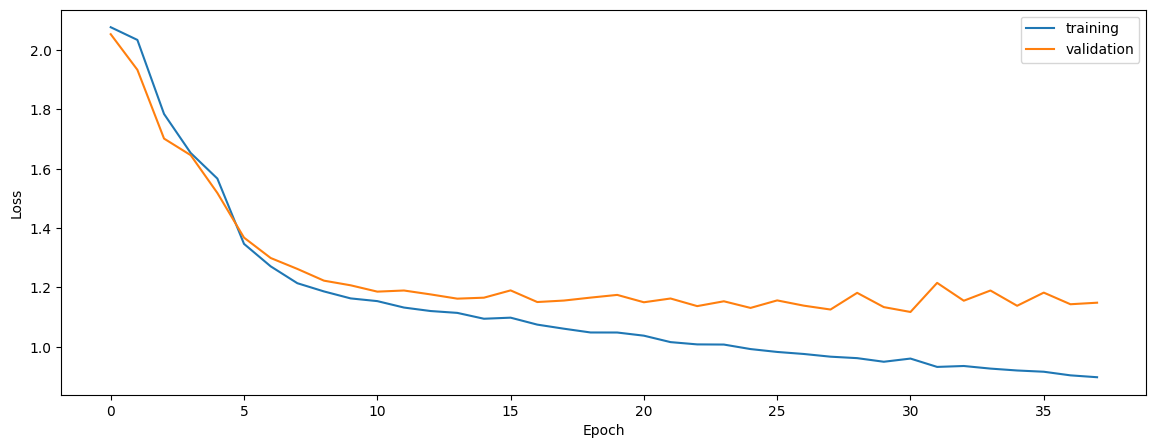

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6364219148307125


0.5787237786408255


0.5911098577062969


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5877653326197119


0.5628937680969633


0.5564047007842491


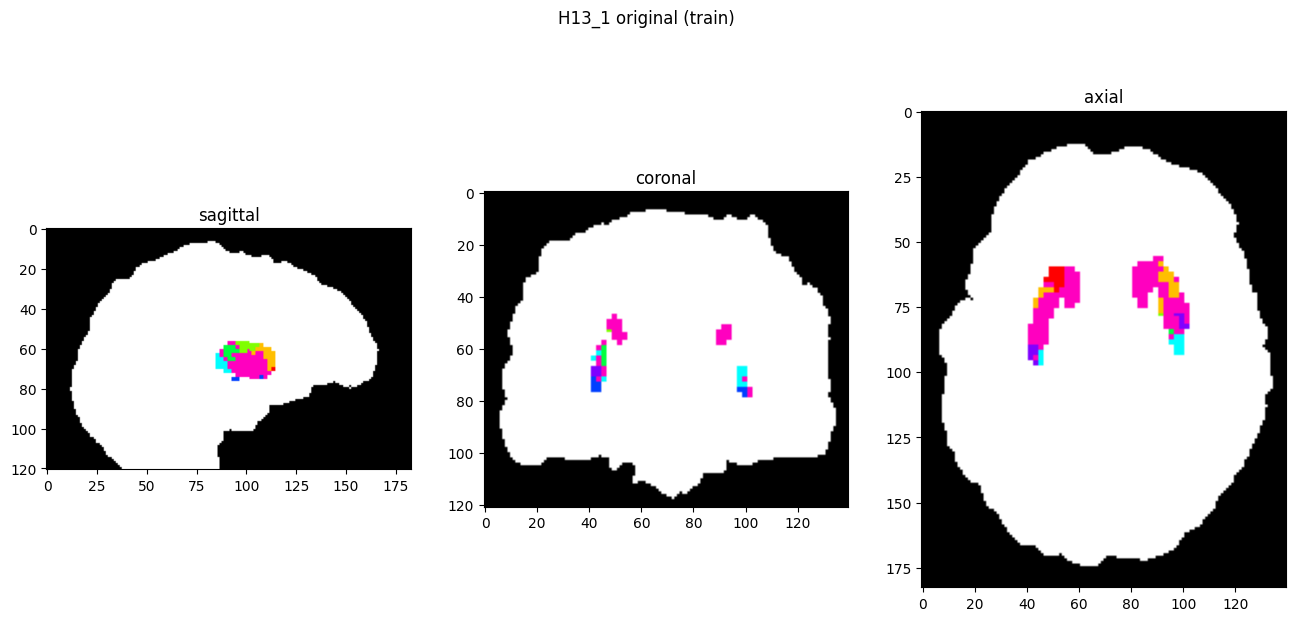

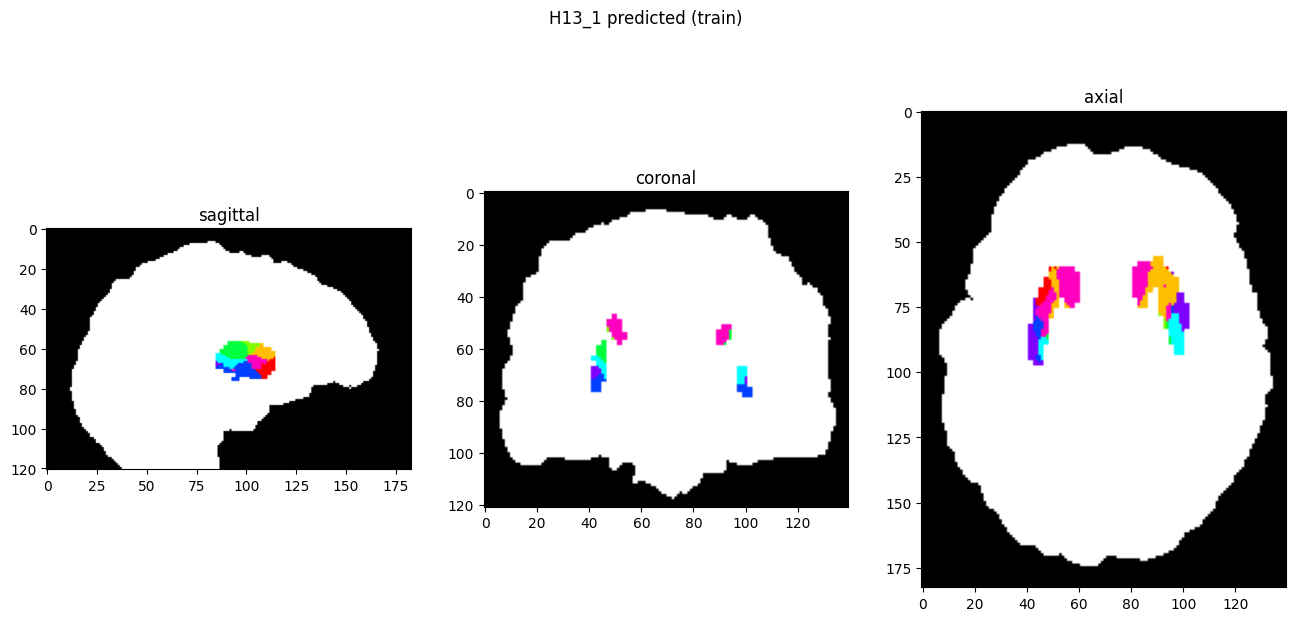

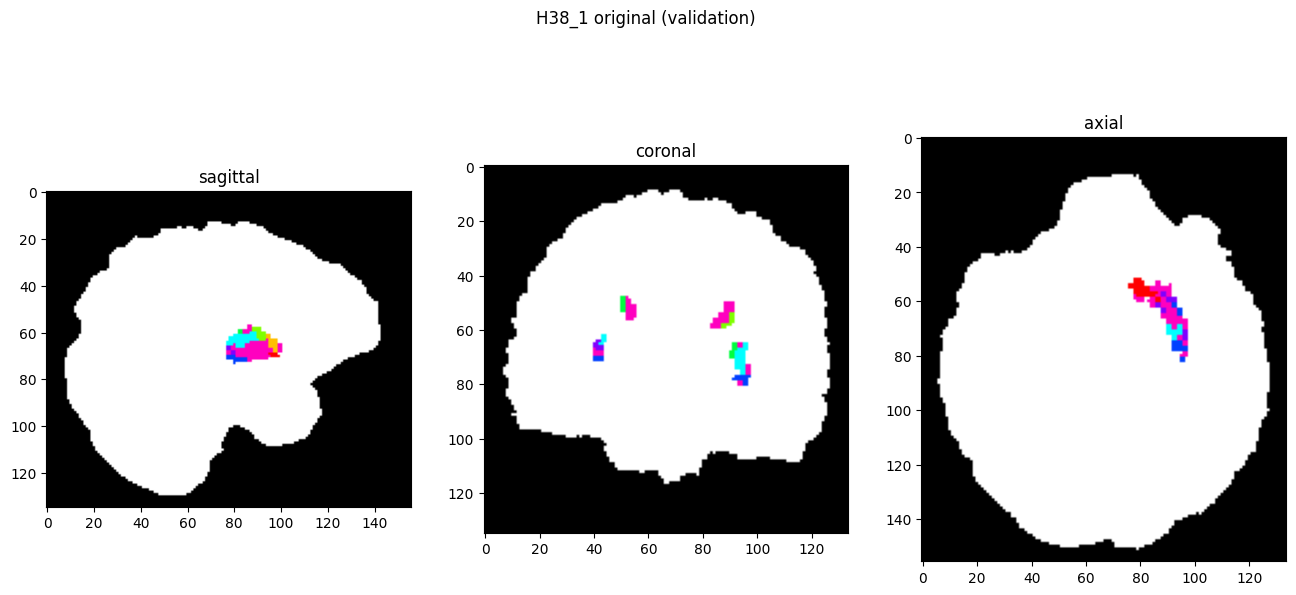

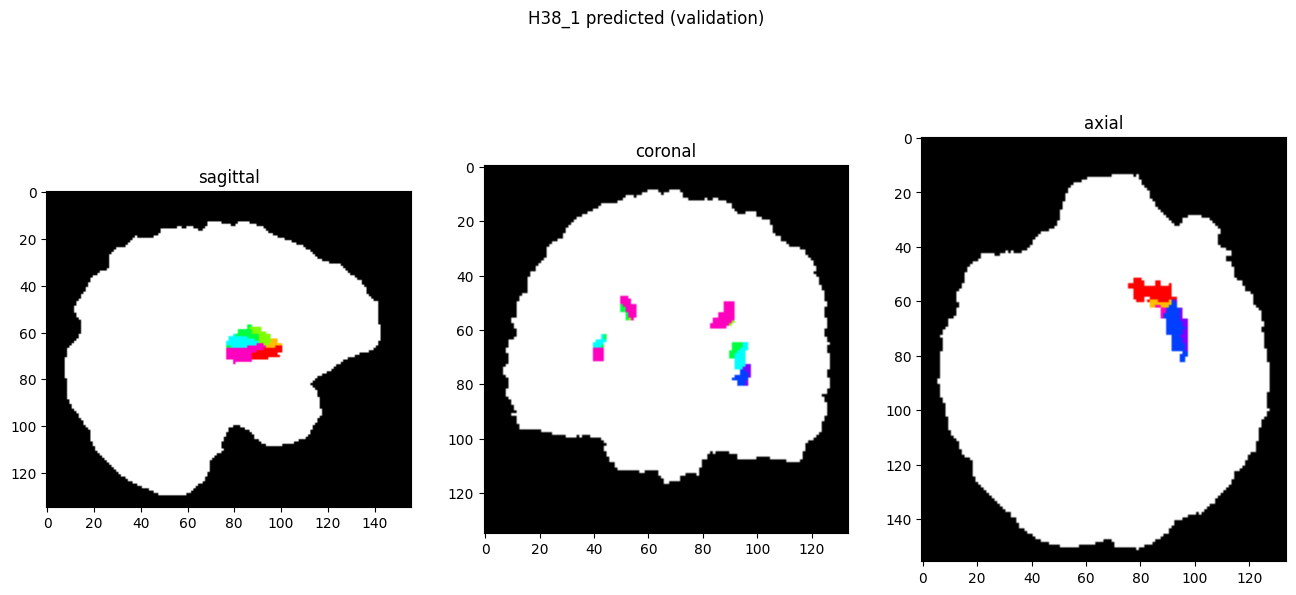

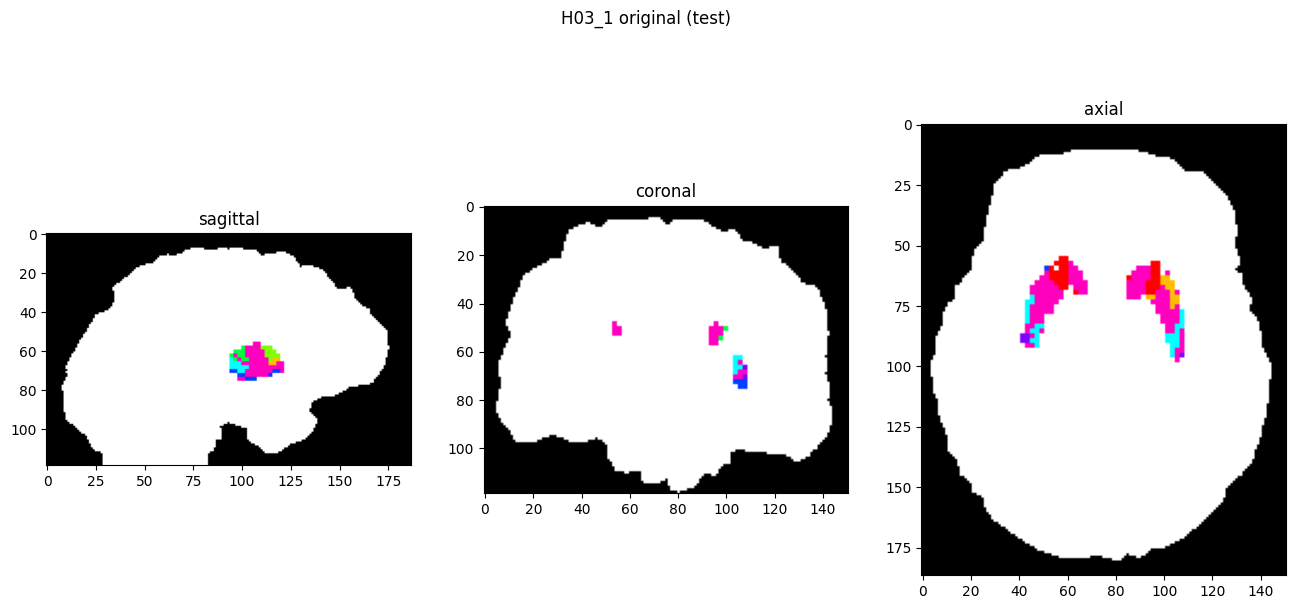

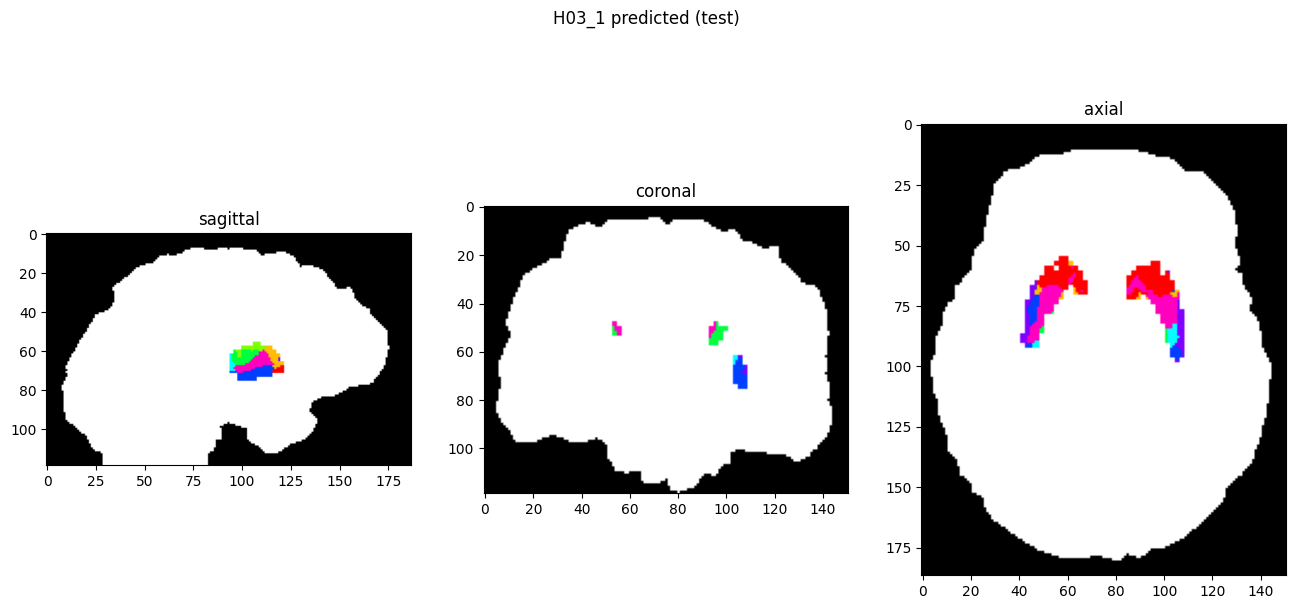

In [9]:
showResults(model, gen, threshold=0)